

```
# Article: https://arxiv.org/pdf/2108.03358
# Source Code (original authors): https://github.com/shuwang127/PatchRNN
# Demo Code (original authors): https://github.com/shuwang127/PatchRNN-demo
# Run Initialisation once, after starting a new Environment in Colab
# Initialisation requires 16 GB RAM and can take a few minutes.
```

# Initialisation



## Helpers

In [ ]:
#STARTIGNORE - helper functions
import os
import requests
from pathlib import Path

def CreateDirectory(path):
  if os.path.exists(path):
    return
  else:
    os.mkdir(path)

def CreateFile(path, content, binary = False):
  if binary == True:
    with open(path, "wb") as f:
      f.write(content)
  else:
    with open(path, "w") as f:
      f.write(content)

def ReadFile(path):
    with open(path, "r", errors="replace") as f:
      return f.read()

def Download(url, dest):
  # Download helper functions from Learn PyTorch repo (if not already downloaded)
  if Path(f"{dest}").is_file():
    print(f"{dest} already exists, skipping download")
  else:
    print(f"Downloading {dest}")
    request = requests.get(url)
    CreateFile(dest,request.content,True)

def GetJsonFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.json()

def GetTextFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.text

def ReleaseGPUMemory():
  import gc
  import torch
  for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()
    try:
      del model
    except:
      pass

def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned() else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned() else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)
#ENDIGNORE



```
# Run this once, after starting a new Environment
# https://github.com/shuwang127/PatchRNN
```

## Data Fetch

In [ ]:
# Get the numpy arrays from repository
!git clone https://github.com/shuwang127/PatchRNN
!mv PatchRNN/analysis .
!mv PatchRNN/data .
!mv PatchRNN/temp .
!rm -r PatchRNN
!unzip -d data/negatives/ data/negatives/20200401N.zip && rm data/negatives/20200401N.zip
!unzip -d data/negatives/ data/negatives/20200512N.zip && rm data/negatives/20200512N.zip
!unzip -d data/negatives/ data/negatives/20200528N.zip && rm data/negatives/20200528N.zip
!unzip -d data/negatives/ data/negatives/20200603N.zip && rm data/negatives/20200603N.zip
!unzip -d data/negatives/ data/negatives/20200618N.zip && rm data/negatives/20200618N.zip
!unzip -d data/negatives/ data/negatives/20200707N.zip && rm data/negatives/20200707N.zip
!unzip -d data/positives/ data/positives/20200401P.zip && rm data/positives/20200401P.zip
!unzip -d data/positives/ data/positives/20200512P.zip && rm data/positives/20200512P.zip
!unzip -d data/positives/ data/positives/20200528P.zip && rm data/positives/20200528P.zip
!unzip -d data/positives/ data/positives/20200603P.zip && rm data/positives/20200603P.zip
!unzip -d data/positives/ data/positives/20200618P.zip && rm data/positives/20200618P.zip
!unzip -d data/positives/ data/positives/20200707P.zip && rm data/positives/20200707P.zip
!unzip -d temp temp/data.zip && rm temp/data.zip
!unzip -d temp temp/msgs.zip && rm temp/msgs.zip
!unzip -d temp temp/props.zip && rm temp/props.zip

Cloning into 'PatchRNN'...
remote: Enumerating objects: 37054, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 37054 (delta 10), reused 9 (delta 9), pack-reused 37040 (from 1)
Receiving objects: 100% (37054/37054), 202.05 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (425/425), done.
mv: cannot move 'PatchRNN/analysis' to './analysis': Directory not empty
mv: cannot move 'PatchRNN/data' to './data': Directory not empty
mv: cannot move 'PatchRNN/temp' to './temp': Directory not empty
unzip:  cannot find or open data/negatives/20200401N.zip, data/negatives/20200401N.zip.zip or data/negatives/20200401N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200512N.zip, data/negatives/20200512N.zip.zip or data/negatives/20200512N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200528N.zip, data/negatives/20200528N.zip.zip or data/negatives/20200528N.zip.ZIP.
unzip:  cannot find or open data/negatives/20200603N.zip, data

## Default Hyperparameters (global variables)



In [ ]:
# @title  {"display-mode":"code"}
# This section contains mostly unchanged code created by:
# Xinda Wang∗, Shu Wang∗, Pengbin Feng∗, Kun Sun∗, Sushil Jajodia∗, Sanae Benchaaboun†, and Frank Geck†∗Center for Secure Information Systems, George Mason University, Fairfax, VA, US† CSIA Division, C5ISR Center, Space and Terrestrial Communications Directorate,U.S. Army Combat Capabilities Development Command (DEVCOM)
# PatchRNN: A Deep Learning-Based System for Security Patch Identification
# Original code can be found here: https://github.com/shuwang127/PatchRNN-demo/tree/main/model
# Shared under Apache 2.0 license: https://github.com/shuwang127/PatchRNN-demo/tree/main?tab=Apache-2.0-1-ov-file#readme
# There might be minor changes that were necessary to port the original code to Transformer-based setup in later sections.

os.system('pip install clang')
import re
import gc
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import clang.cindex
import clang.enumerations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
from sklearn.metrics import accuracy_score

# environment settings.
_COLAB_ = 0 if (os.getenv('COLAB_GPU', 'NONE') == 'NONE') else 1 # 0 : Local environment, 1 : Google Colaboratory.
_COLAB_ = 0
# file paths.
rootPath = './drive/My Drive/Colab Notebooks/' if (_COLAB_) else './'
dataPath = rootPath + '/data/'
sDatPath = dataPath + '/security_patch/'
pDatPath = dataPath + '/positives/'
nDatPath = dataPath + '/negatives/'
tempPath = rootPath + '/temp/'

# hyper-parameters. (affect GPU memory size)
_DiffEmbedDim_  = 128       # 128
_DiffMaxLen_    = 600       # 200(0.7), 314(0.8), 609(0.9), 1100(0.95), 2200(0.98), 3289(0.99), 5000(0.995), 10000(0.9997)
_DRnnHidSiz_    = 16        # 16
_MsgEmbedDim_   = 128       # 128
_MsgMaxLen_     = 200       # 54(0.9), 78(0.95), 130(0.98), 187(0.99), 268(0.995), 356(0.998), 516(0.999), 1434(1)
_MRnnHidSiz_    = 32        # 16
_TwinEmbedDim_  = 128       # 128
_TwinMaxLen_    = 800       # 224(0.8), 425(0.9), 755(0.95), 1448(0.98), 2270(0.99)
_TRnnHidSiz_    = 32        # 16
# hyper-parameters. (affect training speed)
_DRnnBatchSz_   = 128       # 128
_DRnnLearnRt_   = 0.0001    # 0.0001
_MRnnBatchSz_   = 128       # 128
_MRnnLearnRt_   = 0.0001    # 0.0001
_PRnnBatchSz_   = 256       # 256
_PRnnLearnRt_   = 0.0005    # 0.0005
_TRnnBatchSz_   = 256       # 256
_TRnnLearnRt_   = 0.0005    # 0.0005
# hyper-parameters. (trivial network parameters, unnecessary to modify)
_DiffExtraDim_  = 2         # 2
_TwinExtraDim_  = 1         # 1
_DRnnHidLay_    = 1         # 1
_MRnnHidLay_    = 1         # 1
_TRnnHidLay_    = 1         # 1
# hyper-parameters. (epoch related parameters, unnecessary to modify)
_DRnnMaxEpoch_  = 1000      # 1000
_DRnnPerEpoch_  = 1         # 1
_DRnnJudEpoch_  = 10        # 10
_MRnnMaxEpoch_  = 1000      # 1000
_MRnnPerEpoch_  = 1         # 1
_MRnnJudEpoch_  = 10        # 10
_PRnnMaxEpoch_  = 1000      # 1000
_PRnnPerEpoch_  = 1         # 1
_PRnnJudEpoch_  = 10        # 10
_TRnnMaxEpoch_  = 1000      # 1000
_TRnnPerEpoch_  = 1         # 1
_TRnnJudEpoch_  = 10        # 10
# hyper-parameters. (flow control)
_DEBUG_ = 0 #  0 : release
            #  1 : debug
_LOCK_  = 0 #  0 : unlocked - create random split sets.
            #  1 : locked   - use the saved split sets.
_MODEL_ = 0 #  0 : unlocked - train a new model.
            #  1 : locked   - load the saved model.
_DTYP_  = 1 #  0 : maintain both diff code and context code.
            #  1 : only maintain diff code.
_CTYP_  = 0 #  0 : maintain both the code and comments.
            #  1 : only maintain code and delete comments.
_NIND_ =  1 # -1 : not abstract tokens. (and will disable _NLIT_)
            #  0 : abstract identifiers with VAR/FUNC.
            #  1 : abstract identifiers with VARn/FUNCn.
_NLIT_  = 1 #  0 : abstract literals with LITERAL.
            #  1 : abstract literals with LITERAL/n.
_TWIN_  = 1 #  0 : only twin neural network.
            #  1 : twins + msg neural network.

# print setting.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(threshold=np.inf)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Codebase from original article

In [ ]:
# Copied from shuwang127/PatchRNN-demo
# @title SplitData
def SplitData(data, labels, setType, rate=0.2):
    '''
    Split the data and labels into two sets with a specific rate.
    :param data: feature data.
    [[[n, {0~5}, {-1~1}], ...], ...]
    [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, {-1~1}], ...], ...]
    :param labels: labels. [[0/1], ...]
    :param setType: the splited dataset type.
    :param rate: the split rate. 0 ~ 1
    :return: dsetRest - the rest dataset.
             lsetRest - the rest labels.
             dset - the splited dataset.
             lset - the splited labels.
    '''

    # set parameters.
    setType = setType.upper()
    numData = len(data)
    num = math.floor(numData * rate)

    # get the random data list.
    if (os.path.exists(tempPath + '/split_' + setType + '.npy')) & (_LOCK_):
        dataList = np.load(tempPath + '/split_' + setType + '.npy')
    else:
        dataList = list(range(numData))
        random.seed(10)
        random.shuffle(dataList)
        np.save(tempPath + '/split_' + setType + '.npy', dataList, allow_pickle=True)

    # split data.
    dset = data[dataList[0:num]]
    lset = labels[dataList[0:num]]
    dsetRest = data[dataList[num:]]
    lsetRest = labels[dataList[num:]]

    # print.
    setTypeRest = 'TRAIN' if (setType == 'VALID') else 'REST'
    print('[INFO] <SplitData> Split data into ' + str(len(dsetRest)) + ' ' + setTypeRest
          + ' dataset and ' + str(len(dset)) + ' ' + setType + ' dataset. (Total: '
          + str(len(dsetRest) + len(dset)) + ', Rate: ' + str(int(rate * 100)) + '%)')

    return dsetRest, lsetRest, dset, lset

In [ ]:
# @title TwinRNNTrain
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model

In [ ]:
# @title ReadData
def ReadData():
    '''
    Read data from the files.
    :return: data - a set of commit message, diff code, and labels.
    [[['', ...], [['', ...], ['', ...], ...], 0/1], ...]
    '''

    def ReadCommitMsg(filename):
        '''
        Read commit message from a file.
        :param filename: file name (string).
        :return: commitMsg - commit message.
        ['line', 'line', ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        #numLines = len(lines)   # get the line number.
        #print(lines)

        # initialize commit message.
        commitMsg = []
        # get the wide range of commit message.
        for line in lines:
            if line.startswith('diff --git'):
                break
            else:
                commitMsg.append(line)
        #print(commitMsg)
        # process the head of commit message.
        while (1):
            headMsg = commitMsg[0]
            if (headMsg.startswith('From') or headMsg.startswith('Date:') or headMsg.startswith('Subject:')
                    or headMsg.startswith('commit') or headMsg.startswith('Author:')):
                commitMsg.pop(0)
            else:
                break
        #print(commitMsg)
        # process the tail of commit message.
        dashLines = [i for i in range(len(commitMsg))
                     if commitMsg[i].startswith('---')]  # finds all lines start with ---.
        if (len(dashLines)):
            lnum = dashLines[-1]  # last line number of ---
            marks = [1 if (' file changed, ' in commitMsg[i] or ' files changed, ' in commitMsg[i]) else 0
                     for i in range(lnum, len(commitMsg))]
            if (sum(marks)):
                for i in reversed(range(lnum, len(commitMsg))):
                    commitMsg.pop(i)
        #print(commitMsg)

        #msgShow = ''
        #for i in range(len(commitMsg)):
        #    msgShow += commitMsg[i]
        #print(msgShow)

        return commitMsg

    def ReadDiffLines(filename):
        '''
        Read diff code from a file.
        :param filename:  file name (string).
        :return: diffLines - diff code.
        [['line', ...], ['line', ...], ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        numLines = len(lines)  # get the line number.
        # print(filename)

        atLines = [i for i in range(numLines) if lines[i].startswith('@@ ')]  # find all lines start with @@.
        atLines.append(numLines)
        # print(atLines)

        diffLines = []
        for nh in range(len(atLines) - 1):  # find all hunks.
            # print(atLines[nh], atLines[nh + 1])
            hunk = []
            for nl in range(atLines[nh] + 1, atLines[nh + 1]):
                # print(lines[nl], end='')
                if lines[nl].startswith('diff --git '):
                    break
                else:
                    hunk.append(lines[nl])
            diffLines.append(hunk)
            # print(hunk)
        # print(diffLines)
        # print(len(diffLines))

        # process the last hunk.
        lastHunk = diffLines[-1]
        numLastHunk = len(lastHunk)
        dashLines = [i for i in range(numLastHunk) if lastHunk[i].startswith('--')]
        if (len(dashLines)):
            lnum = dashLines[-1]
            for i in reversed(range(lnum, numLastHunk)):
                lastHunk.pop(i)
        # print(diffLines)
        # print(len(diffLines))

        return diffLines

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'filelist.txt', 'w')

    # initialize data.
    data = []
    # read security patch data.
    for root, ds, fs in os.walk(sDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read positive data.
    for root, ds, fs in os.walk(pDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read negative data.
    for root, ds, fs in os.walk(nDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 0])
    fp.close()

    #print(len(dataLoaded))
    #print(len(dataLoaded[0]))
    #print(dataLoaded)
    # [[['a', 'b', 'c', ], [['', '', '', ], ['', '', '', ], ], 0/1], ]
    # sample = dataLoaded[i]
    # commitMsg = dataLoaded[i][0]
    # diffLines = dataLoaded[i][1]
    # label = dataLoaded[i][2]
    # diffHunk = dataLoaded[i][1][j]

    # save dataLoaded.
    if not os.path.exists(tempPath + '/data.npy'):
        np.save(tempPath + '/data.npy', data, allow_pickle=True)
        print('[INFO] <ReadData> Save ' + str(len(data)) + ' raw data to ' + tempPath + '/data.npy.')

    return data

In [ ]:
# @title GetDiffProps
def GetDiffProps(data):
    '''
    Get the properties of the code in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: props - [[[tokens], [nums], [nums], 0/1], ...]
    '''

    def RemoveSign(line):
        '''
        Remove the sign (+/-) in the first character.
        :param line: a code line.
        :return: process line.
        '''

        return ' ' + line[1:] if (line[0] == '+') or (line[0] == '-') else line

    def GetClangTokens(line):
        '''
        Get the tokens of a line with the Clang tool.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # remove non-ascii
        line = line.encode("ascii", "ignore").decode()

        # defination.
        tokenClass = [clang.cindex.TokenKind.KEYWORD,      # 1
                      clang.cindex.TokenKind.IDENTIFIER,   # 2
                      clang.cindex.TokenKind.LITERAL,      # 3
                      clang.cindex.TokenKind.PUNCTUATION,  # 4
                      clang.cindex.TokenKind.COMMENT]      # 5
        tokenDict = {cls: index + 1 for index, cls in enumerate(tokenClass)}
        #print(tokenDict)

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # clang sparser.
        idx = clang.cindex.Index.create()
        tu = idx.parse('tmp.cpp', args=['-std=c++11'], unsaved_files=[('tmp.cpp', RemoveSign(line))], options=0)
        for t in tu.get_tokens(extent=tu.cursor.extent):
            #print(t.kind, t.spelling, t.location)
            tokens.append(t.spelling)
            tokenTypes.append(tokenDict[t.kind])
            diffTypes.append(1 if (line[0] == '+') else -1 if (line[0] == '-') else 0)
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    def GetWordTokens(line):
        '''
        Get the word tokens from a code line.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
        '''

        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(RemoveSign(line))
        return tokens

    def GetString(lines):
        '''
        Get the strings from the diff code
        :param lines: diff code.
        :return: lineStr - All the diff lines.
                 lineStrB - The before-version code lines.
                 lineStrA - The after-version code lines.
        '''

        lineStr = ''
        lineStrB = ''
        lineStrA = ''
        for hunk in lines:
            for line in hunk:
                # all lines.
                lineStr += RemoveSign(line)
                # all Before lines.
                lineStrB += RemoveSign(line) if line[0] != '+' else ''
                # all After lines.
                lineStrA += RemoveSign(line) if line[0] != '-' else ''

        return lineStr, lineStrB, lineStrA

    def GetDiffTokens(lines):
        '''
        Get the tokens for the diff lines.
        :param lines: the diff code.
        :return: tokens - tokens ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - token types [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - diff types [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # for each line of lines.
        for hunk in lines:
            for line in hunk:
                #print(line, end='')
                tk, tkT, dfT = GetClangTokens(line)
                tokens.extend(tk)
                tokenTypes.extend(tkT)
                diffTypes.extend(dfT)
                #print('-----------------------------------------------------------------------')
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    #lines = data[0][1]
    #print(lines)
    #hunk = data[0][1][0]
    #print(hunk)
    #line = data[0][1][0][0]
    #print(line)

    # for each sample data[n].
    numData = len(data)
    props = []
    for n in range(numData):
        # get the lines of the diff file.
        diffLines = data[n][1]
        # properties.
        tk, tkT, dfT = GetDiffTokens(diffLines)
        label = data[n][2]
        prop = [tk, tkT, dfT, label]
        #print(prop)
        props.append(prop)
        print(n)

    # save props.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/props.npy'):
        np.save(tempPath + '/props.npy', props, allow_pickle=True)
        print('[INFO] <GetDiffProps> Save ' + str(len(props)) + ' diff property data to ' + tempPath + '/props.npy.')

    return props

In [ ]:
# @title ProcessTokens
def ProcessTokens(props, dType=1, cType=1):
    '''
    only maintain the diff parts of the code.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param dType: 0 - maintain both diff code and context code.
                  1 - only maintain diff code.
    :param cType: 0 - maintain both the code and comments.
                  1 - only maintain code and delete comments.
    :return: props - the normalized features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    # process diff code.
    if (1 == dType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[2][n])]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[2][n])]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[2][n])]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Only maintain the diff parts of the code.')

    # process comments.
    if (1 == cType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[1][n] < 5)]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[1][n] < 5)]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[1][n] < 5)]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Delete the comment parts of the diff code.')

    #print(props[0])

    return props

In [ ]:
# @title AbstractTokens
def AbstractTokens(props, iType=1, lType=1):
    '''
    abstract the tokens of identifiers, literals, and comments.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param iType:   -1 - not abstract tokens.
                     0 - only abstract variable type and function type. VAR / FUNC
                     1 - abstract the identical variable names and function names.  VAR0, VAR1, ... / FUNC0, FUNC1, ...
    :param lType:   -1 - not abstract tokens.
                     0 - abstract literals with LITERAL.
                     1 - abstract literals with LITERAL/n.
    :return: props - the abstracted features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    if (iType not in [0, 1]) or (lType not in [0, 1]):
        print('[INFO] <AbstractTokens> Not abstract the tokens of identifiers, literals, and comments.')
        return props

    for item in props:
        # get tokens and token types.
        tokens = item[0]
        tokenTypes = item[1]
        numTokens = len(tokenTypes)
        #print(tokens)
        #print(tokenTypes)
        #print(numTokens)

        # abstract literals and comments, and separate identifiers into variables and functions.
        markVar = list(np.zeros(numTokens, dtype=int))
        markFuc = list(np.zeros(numTokens, dtype=int))
        for n in range(numTokens):
            # 2: IDENTIFIER, 3: LITERAL, 5: COMMENT
            if 5 == tokenTypes[n]:
                tokens[n] = 'COMMENT'
            elif 3 == tokenTypes[n]:
                if (0 == lType):
                    tokens[n] = 'LITERAL'
                elif (1 == lType):
                    if (not tokens[n].isdigit()):
                        tokens[n] = 'LITERAL'
            elif 2 == tokenTypes[n]:
                # separate variable name and function name.
                if (n < numTokens-1):
                    if (tokens[n+1] == '('):
                        markFuc[n] = 1
                    else:
                        markVar[n] = 1
                else:
                    markVar[n] = 1
        #print(tokens)
        #print(markVar)
        #print(markFuc)

        # abstract variables and functions.
        if (0 == iType):
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = 'VAR'
                elif 1 == markFuc[n]:
                    tokens[n] = 'FUNC'
        elif (1 == iType):
            # get variable dictionary.
            varList = [tokens[idx] for idx, mark in enumerate(markVar) if mark == 1]
            varVoc  = {}.fromkeys(varList)
            varVoc  = list(varVoc.keys())
            varDict = {tk: 'VAR' + str(idx) for idx, tk in enumerate(varVoc)}
            # get function dictionary.
            fucList = [tokens[idx] for idx, mark in enumerate(markFuc) if mark == 1]
            fucVoc  = {}.fromkeys(fucList)
            fucVoc  = list(fucVoc.keys())
            fucDict = {tk: 'FUNC' + str(idx) for idx, tk in enumerate(fucVoc)}
            #print(varDict)
            #print(fucDict)
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = varDict[tokens[n]]
                elif 1 == markFuc[n]:
                    tokens[n] = fucDict[tokens[n]]
    #print(tokens)
    print('[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType ' + str(iType), end='')
    print(' (VAR/FUNC).') if (0 == iType) else print(' (VARn/FUNCn).')
    print('[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType ' + str(lType), end='')
    print(' (LITERAL/COMMENT).') if (0 == lType) else print(' (LITERAL/n/COMMENT).')

    return props

In [ ]:
# @title GetDiffVocab
def GetDiffVocab(props):
    '''
    Get the vocabulary of diff tokens
    :param props - the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :return: vocab - the vocabulary of diff tokens. ['tk', 'tk', ...]
             maxLen - the max length of a diff code.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'difflen.csv', 'w')

    # get the whole tokens and the max diff length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in props:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetDiffVocab> There are ' + str(len(vocab)) + ' diff vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetDiffVocab> The max diff length is ' + str(maxLen) + ' tokens. (hyperparameter: _DiffMaxLen_ = ' + str(_DiffMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetDiffDict
def GetDiffDict(vocab):
    '''
    Get the dictionary of diff vocabulary.
    :param vocab: the vocabulary of diff tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetDiffDict> Create dictionary for ' + str(len(tokenDict)) + ' diff vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetDiffEmbed
def GetDiffEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of diff vocabulary.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetDiffEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/preWeights.npy'):
        np.save(tempPath + '/preWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetDiffEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/preWeights.npy.')

    return preWeights

In [ ]:
# @title DivideBeforeAfter
def DivideBeforeAfter(diffProps):

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'twinlen.csv', 'w')

    twinProps = []
    maxLen = 0
    # for each sample in diffProps.
    for item in diffProps:
        # get the tk, tkT, dfT, lb.
        tokens = item[0]
        tokenTypes = item[1]
        diffTypes = item[2]
        label = item[3]
        numTokens = len(diffTypes)
        # reconstruct tkB, tkTB, tkA, tkTA.
        tokensB = [tokens[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokenTypesB = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokensA = [tokens[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        tokenTypesA = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        # reconstruct new sample.
        sample = [tokensB, tokenTypesB, tokensA, tokenTypesA, label]
        twinProps.append(sample)
        # get max length.
        maxLenAB = max(len(tokenTypesB), len(tokenTypesA))
        maxLen = maxLenAB if (maxLen < maxLenAB) else maxLen
        fp.write(str(len(tokenTypesB)) + '\n')
        fp.write(str(len(tokenTypesA)) + '\n')
    fp.close()

    #print(twinProps[0])
    #print(maxLen)

    # print.
    print('[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.')
    print('[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is ' + str(maxLen) + ' tokens. (hyperparameter: _TwinMaxLen_ = ' + str(_TwinMaxLen_) + ')')

    return twinProps, maxLen

In [ ]:
# @title GetTwinMapping
def GetTwinMapping(props, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of diff code.
    [[[tokens], [nums], [tokens], [nums], 0/1], ...]
    :param maxLen: the max length of a twin code.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[[n, {0~5}, n, {0~5}], ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in props:
        # initialize sample.
        sample = []

        # process tokensB.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesB.
        tokenTypes = item[1]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)
        # process tokensA.
        tokens = item[2]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesA.
        tokenTypes = item[3]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)

        # process sample.
        sample = np.array(sample).T
        data.append(sample)
        # process label.
        label = item[4]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetTwinMapping> Create ' + str(len(data)) + ' feature data with ' + str(len(data[0])) + ' * ' + str(len(data[0][0])) + ' matrix.')
    print('[INFO] <GetTwinMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/tdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/tlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/tdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy data to ' + tempPath + '/tdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/tlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy labels to ' + tempPath + '/tlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title UpdateTwinTokenTypes
def UpdateTwinTokenTypes(data):
    '''
    Update the token type in the feature data into one-hot vector.
    :param data: feature data. [[[n, {0~5}, n, {0~5},], ...], ...]
    :return: np.array(newData). [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    '''

    newData = []
    # for each sample.
    for item in data:
        # get the transpose of props.
        itemT = item.T
        # initialize new sample.
        newItem = []
        newItem.append(itemT[0])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        newItem.append(itemT[2])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        # assign the new sample.
        for i in range(len(item)):
            tokenType = itemT[1][i]
            if (tokenType):
                newItem[tokenType][i] = 1
            tokenType = itemT[3][i]
            if (tokenType):
                newItem[tokenType+6][i] = 1
        # get the transpose of new sample.
        newItem = np.array(newItem).T
        # append new sample.
        newData.append(newItem)

    if _DEBUG_:
        print('[DEBUG] newData:')
        print(newData[0:3])

    # print.
    print('[INFO] <UpdateTwinTokenTypes> Update ' + str(len(newData)) + ' feature data with ' + str(len(newData[0])) + ' * ' + str(len(newData[0][0])) + ' matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy')):
        np.save(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy', newData, allow_pickle=True)
        print('[INFO] <UpdateTwinTokenTypes> Save the mapped numpy data to ' + tempPath + '/newtdata_' + str(len(newData[0])) + '.npy.')

    # change marco.
    global _TwinExtraDim_
    _TwinExtraDim_ = 5

    return np.array(newData)

In [ ]:
# @title GetCommitMsgs
def GetCommitMsgs(data):
    '''
    Get the commit messages in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: msgs - [[[tokens], 0/1], ...]
    '''

    def GetMsgTokens(lines):
        '''
        Get the tokens from a commit message.
        :param lines: commit message. [line, , ]
        :return: tokensStem ['tk', , ]
        '''

        # concatenate lines.
        # get the string of commit message.
        msg = ''
        for line in lines:
            msg += line[:-1] + ' '
        #print(msg)

        # pre-process.
        # remove url.
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        msg = re.sub(pattern, ' ', msg)
        # remove independent numbers.
        pattern = r' \d+ '
        msg = re.sub(pattern, ' ', msg)
        # lower case capitalized words.
        pattern = r'([A-Z][a-z]+)'
        def LowerFunc(matched):
            return matched.group(1).lower()
        msg = re.sub(pattern, LowerFunc, msg)
        # remove footnote.
        patterns = ['signed-off-by:', 'reported-by:', 'reviewed-by:', 'acked-by:', 'found-by:', 'tested-by:', 'cc:']
        for pattern in patterns:
            index = msg.find(pattern)
            if (index > 0):
                msg = msg[:index]
        #print(msg)

        # clearance.
        # get the tokens.
        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(msg)
        # clear tokens that don't contain any english letter.
        for i in reversed(range(len(tokens))):
            if not (re.search('[a-z]', tokens[i])):
                tokens.pop(i)
        # clear tokens that are stopwords.
        for i in reversed(range(len(tokens))):
            if (tokens[i] in stopwords.words('english')):
                tokens.pop(i)
        pattern = re.compile("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
        for i in reversed(range(len(tokens))):
            if (pattern.findall(tokens[i])):
                tokens.pop(i)
        #print(tokens)

        # process tokens with stemming.
        porter = PorterStemmer()
        tokensStem = []
        for item in tokens:
            tokensStem.append(porter.stem(item))
        #print(tokensStem)

        return tokensStem

    # for each sample data[n].
    numData = len(data)
    msgs = []
    for n in range(numData):
        # get the lines of the commit message.
        commitMsg = data[n][0]
        mtk = GetMsgTokens(commitMsg)
        # get the label.
        label = data[n][2]
        #print([mtk, label])
        # append the message tokens.
        msgs.append([mtk, label])
        print(n)

    # save commit messages.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/msgs.npy'):
        np.save(tempPath + '/msgs.npy', msgs, allow_pickle=True)
        print('[INFO] <GetCommitMsg> Save ' + str(len(msgs)) + ' commit messages to ' + tempPath + '/msgs.npy.')

    return msgs

In [ ]:
# @title GetMsgVocab
def GetMsgVocab(msgs):
    '''
    Get the vocabulary of message tokens
    :param msgs - [[[tokens], 0/1], ...]
    :return: vocab - the vocabulary of message tokens. ['tk', 'tk', ...]
             maxLen - the max length of a commit message.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'msglen.csv', 'w')

    # get the whole tokens and the max msg length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in msgs:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetMsgVocab> There are ' + str(len(vocab)) + ' commit message vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetMsgVocab> The max msg length is ' + str(maxLen) + ' tokens. (hyperparameter: _MsgMaxLen_ = ' + str(_MsgMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetMsgDict
def GetMsgDict(vocab):
    '''
    Get the dictionary of msg vocabulary.
    :param vocab: the vocabulary of msg tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of msg vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetMsgDict> Create dictionary for ' + str(len(tokenDict)) + ' msg vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetMsgEmbed
def GetMsgEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of msg vocabulary.
    :param tokenDict: the dictionary of msg vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetMsgEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/msgPreWeights.npy'):
        np.save(tempPath + '/msgPreWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetMsgEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/msgPreWeights.npy.')

    return preWeights

In [ ]:
# @title GetMsgMapping
def GetMsgMapping(msgs, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of commit messages.
    [[[tokens], 0/1], ...]
    :param maxLen: the max length of the commit message.
    :param tokenDict: the dictionary of commit message vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[n, ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in msgs:
        # process tokens.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        # convert tokens into numbers.
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        data.append(tokens2index)
        # process label.
        label = item[1]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetMsgMapping> Create ' + str(len(data)) + ' feature data with 1 * ' + str(len(data[0])) + ' vector.')
    print('[INFO] <GetMsgMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/mdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/mlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/mdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy data to ' + tempPath + '/mdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/mlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy labels to ' + tempPath + '/mlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title CombineTwinMsgs
def CombineTwinMsgs(props, msgs, plabels, mlabels):
    '''
    Combine the twin props with the commit messages.
    :param props: twin data. [[[n, {0~5}, n, {0~5}], ...], ...] or [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    :param msgs: message data. [[n, ...], ...]
    :param plabels: twin labels. [[0/1], ...]
    :param mlabels: message labels. [[0/1], ...]
    :return: np.array(data) - combined data. [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1, n], ...], ...]
             np.array(plabels) - combined labels. [[0/1], ...]
    '''

    # check the lengths.
    if (len(plabels) != len(mlabels)):
        print('[ERROR] <CombineTwinMsgs> the data lengths are mismatch.')
        return [[]], [[]]

    # check the labels.
    cntMatch = 0
    for n in range(len(plabels)):
        if (plabels[n][0] == mlabels[n][0]):
            cntMatch += 1
    if (cntMatch != len(plabels)):
        print('[ERROR] <CombineTwinMsgs> the labels are mismatch. ' + str(cntMatch) + '/' + str(len(plabels)) + '.')
        return [[]], [[]]

    #print(props[1], len(props[1]))
    #print(msgs[1], len(msgs[1]))

    data = []
    for n in range(len(plabels)):
        # get the twin prop and message.
        prop = props[n]
        msg = msgs[n]
        # pad data.
        if (_TwinMaxLen_ >= _MsgMaxLen_):
            msg = np.pad(msg, (0, _TwinMaxLen_ - _MsgMaxLen_), 'constant')
        else:
            prop = np.pad(prop, ((0, _MsgMaxLen_ - _TwinMaxLen_), (0, 0)), 'constant')
        #print(msg, len(msg))
        #print(prop, len(prop))
        # reconstruct sample.
        sample = np.vstack((prop.T, msg))
        # append the sample to data.
        data.append(sample.T)

    if _DEBUG_:
        print(np.array(data[0:3]))

    print('[INFO] <CombineTwinMsgs> Combine the twin props with the commit messages.')

    return np.array(data), np.array(plabels)

In [ ]:
# @title OutputEval
def OutputEval(predictions, labels, method=''):
    '''
    Output the evaluation results.
    :param predictions: predicted labels. [[0], [1], ...]
    :param labels: ground truth labels. [[1], [1], ...]
    :param method: method name. string
    :return: accuracy - the total accuracy. numeric
             confusion - confusion matrix [[1000, 23], [12, 500]]
    '''

    # evaluate the predictions with gold labels, and get accuracy and confusion matrix.
    def Evaluation(predictions, labels):

        # parameter settings.
        D = len(labels)
        cls = 2

        # get confusion matrix.
        confusion = np.zeros((cls, cls))
        for ind in range(D):
            nRow = int(predictions[ind][0])
            nCol = int(labels[ind][0])
            confusion[nRow][nCol] += 1

        # get accuracy.
        accuracy = 0
        for ind in range(cls):
            accuracy += confusion[ind][ind]
        accuracy /= D

        return accuracy, confusion

    # get accuracy and confusion matrix.
    accuracy, confusion = Evaluation(predictions, labels)
    precision = confusion[1][1] / (confusion[1][0] + confusion[1][1]) if (confusion[1][0] + confusion[1][1]) else 0
    recall = confusion[1][1] / (confusion[0][1] + confusion[1][1]) if (confusion[0][1] + confusion[1][1]) else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # output on screen and to file.
    print('       -------------------------------------------')
    print('       method           :  ' +  method) if len(method) else print('', end='')
    print('       accuracy  (ACC)  :  %.3f%%' % (accuracy * 100))
    print('       precision (P)    :  %.3f%%' % (precision * 100))
    print('       recall    (R)    :  %.3f%%' % (recall * 100))
    print('       F1 score  (F1)   :  %.3f' % (F1))
    print('       fall-out  (FPR)  :  %.3f%%' % (confusion[1][0] * 100 / (confusion[1][0] + confusion[0][0])))
    print('       miss rate (FNR)  :  %.3f%%' % (confusion[0][1] * 100 / (confusion[0][1] + confusion[1][1])))
    print('       confusion matrix :      (actual)')
    print('                           Neg         Pos')
    print('       (predicted) Neg     %-5d(TN)   %-5d(FN)' % (confusion[0][0], confusion[0][1]))
    print('                   Pos     %-5d(FP)   %-5d(TP)' % (confusion[1][0], confusion[1][1]))
    print('       -------------------------------------------')

    return accuracy, confusion

## Loading data to memory

In [ ]:
# load data.
if (not os.path.exists(tempPath + '/data.npy')):  # | (not _DEBUG_)
    dataLoaded = ReadData()
else:
    dataLoaded = np.load(tempPath + '/data.npy', allow_pickle=True)
    print('[INFO] <ReadData> Load ' + str(len(dataLoaded)) + ' raw data from ' + tempPath + '/data.npy.')

# get the diff file properties.
if (not os.path.exists(tempPath + '/props.npy')):
    diffProps = GetDiffProps(dataLoaded)
else:
    diffProps = np.load(tempPath + '/props.npy', allow_pickle=True)
    print('[INFO] <GetDiffProps> Load ' + str(len(diffProps)) + ' diff property data from ' + tempPath + '/props.npy.')
# maintain both the context and diff parts. Delete comments.
diffProps = ProcessTokens(diffProps, dType=0, cType=_CTYP_)
# normalize the tokens of identifiers (VARn/FUNCn), literals (LITERAL/n), and comments (none).
diffProps = AbstractTokens(diffProps, iType=_NIND_, lType=_NLIT_)
# get the diff token vocabulary.
diffVocab, _ = GetDiffVocab(diffProps)
# TS: Noting exceptional up to this point. :TS
# get the diff token dictionary.
diffDict = GetDiffDict(diffVocab)
# TS:
# diffDict contains encodings based on the input code. It's not extensible for new keyword tokens at this point. E.g  while is encoded as 1
# List of standard key-value pairs where k:str and v:int
# :TS
# get pre-trained weights for embedding layer.
twinPreWeights = GetDiffEmbed(diffDict, _TwinEmbedDim_)
# divide diff code into before/after-version code.
twinProps, twinMaxLen = DivideBeforeAfter(diffProps)
# TS: At this point twinProps are in the following format
# every item in twinProps is a list of 4 items
# [[beforestr1,...,beforestrN] , [beforestrType1,...,beforestrType1] , [afterstr1,...,afterstrN] , [afterstrType1,...,afterstrTypeN]]
# where beforestr1 can be e.g while and thus beforestrType1 will be 1 (1 == keyword)
# :TS
# get the max twin length.
twinMaxLen = _TwinMaxLen_ if (twinMaxLen > _DiffMaxLen_) else twinMaxLen
# get the mapping for feature data and labels.
twinData, twinLabels = GetTwinMapping(twinProps, twinMaxLen, diffDict)
# TS:
# At this point every item in twinData is a 2-d array:
# [[encodedtoken0B, encodedtokenType0B, encodedtoken0A, encodedTokenType0A], ..., [encodedtokenNB, encodedtokenTypeNB, encodedtokenNA, encodedTokenTypeNA]
# The lenghts are 'padded'
# :TS
# change the tokentypes into one-hot vector.
twinData = UpdateTwinTokenTypes(twinData)
# TS: Note that this encodes only token-types, the tokenID remains an integer value, which is fine, because then we have embeddings:
# e.g: [[ 1  1  0  0  0  0  1  1  0  0  0  0],
# [ 2  0  0  0  1  0  2  0  0  0  1  0],
# [ 3  0  0  0  1  0  3  0  0  0  1  0]....
# Each row is [tokenB 5x tokenTypeB.onehot tokenA 5x tokenTypeA.onehot]
# get the commit messages from data.
if (not os.path.exists(tempPath + '/msgs.npy')):
    commitMsgs = GetCommitMsgs(dataLoaded)
else:
    commitMsgs = np.load(tempPath + '/msgs.npy', allow_pickle=True)
    print('[INFO] <GetCommitMsg> Load ' + str(len(commitMsgs)) + ' commit messages from ' + tempPath + '/msgs.npy.')
# TS: Loaded messages are only key words + label, they are no longer structured like a normal message.
# e.g: [list(['dv', 'fix', 'null', 'pointer', 'derefer', 'due', 'ach', 'fix', 'part']) 1]
# :TS
# get the message token vocabulary.
msgVocab, msgMaxLen = GetMsgVocab(commitMsgs)
# get the max msg length.
msgMaxLen = _MsgMaxLen_ if (msgMaxLen > _MsgMaxLen_) else msgMaxLen
# get the msg token dictionary.
# TS: Every token found in messages is converted to dict (it's not just words, they are detected in more elaborate fashion, for example word 'architecture' becomes 'architectur')
# :TS
msgDict = GetMsgDict(msgVocab)
# TS: Straightforward "token" to "int"
# :TS
# get pre-trained weights for embedding layer.
msgPreWeights = GetMsgEmbed(msgDict, _MsgEmbedDim_)
# get the mapping for feature data and labels.
msgData, msgLabels = GetMsgMapping(commitMsgs, msgMaxLen, msgDict)
# TS:
# msgData items are just lists of tokens. (padded and not one-hot encoded, which is fine, because then we we have embeddings)
# [ 1  2  3  4  5  6  7  8  3  4  9 10 11 12 13 14 15  3  4  0  0  0 ... padding .... 0]
# :TS
# combine the twin data with the message data.
data, label = CombineTwinMsgs(twinData, msgData, twinLabels, msgLabels)
# TS:
# Every data item is the following:
#[[ 4  0  1  0  0  0  4  0  1  0  0  0  1]
# [21  0  0  0  1  0 21  0  0  0  1  0  2]
# ....
# [[tokenB, 5x one-hotTypeB, tokenA, 5x one-hotTypeA, msgToken]....
# Last column is simply message tokens encoded
# :TS

[INFO] <ReadData> Load 38041 raw data from .//temp//data.npy.
[INFO] <GetDiffProps> Load 38041 diff property data from .//temp//props.npy.
[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType 1 (VARn/FUNCn).
[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType 1 (LITERAL/n/COMMENT).
[INFO] <GetDiffVocab> There are 35575 diff vocabulary tokens. (except '<pad>')
[INFO] <GetDiffVocab> The max diff length is 2706522 tokens. (hyperparameter: _DiffMaxLen_ = 600)
[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
[INFO] <GetDiffEmbed> Create pre-trained embedding weights with 35576 * 128 matrix.
[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.
[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is 1938015 tokens. (hyperparameter: _TwinMaxLen_ = 800)
[INFO] <GetTwinMapping> Create 38041 feature data with 800 * 4 matrix.
[INFO] <GetTwinMapping> Create 38041

# Network Training - LSTM (original)

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
import time
# @title class TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())
        return self.softmax(final_out)      # batch_size * class_num

In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TRnnMaxEpoch_  = 20      # 1000
_TRnnPerEpoch_  = 1         # 1
_TRnnJudEpoch_  = 10        # 10
_TTransformerBatchSz_ = 128
_TTransformerLearnRt_ = 0.0005

### Test/Train Definitions

In [ ]:
# @title TwinRNN Train Definition
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long()
    yTrain = torch.from_numpy(lTrain).long()
    xValid = torch.from_numpy(dValid).long()
    yValid = torch.from_numpy(lValid).long()
    if (markTest):
        xTest = torch.from_numpy(dTest).long()
        yTest = torch.from_numpy(lTest).long()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights)

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = "cpu"
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []
    execution_times = []

    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    print(f"Total execution time {sum(execution_times):.6f}")

    return model,accList, execution_times, accL, validAccL, lossL


In [ ]:
# @title Test TwinRNN Definition
def TwinRNNTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long()
    yTest = torch.from_numpy(lTest).long()

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # testing phase.
    execution_times = []
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

## Run

In [ ]:
# @title RunRNN
def RunRNN():
  # TwinRNNTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinRNN.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
  else:
      model, acc,execution_times,accL, validAccL, lossL = TwinRNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinRNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinRNN')

  return model, acc,execution_times,accL, validAccL, lossL

In [ ]:
# This code runs default setup by original authors of the article (with hyperparameter changes)
# The result is that we can easily achieve 82% accuracy on test dataset in <10 epochs.
# [Epoch 010] loss: 0.399, train acc: 91.910%, valid acc: 83.899%, test acc: 83.899%.
# This model uses: 1. Code before, 2. Code after, 3. Commit Messages to
model,_,execution_times,accL, validAccL, lossL = RunRNN()

[INFO] <TwinRNNTrain> ModelType: TwinRNN.
[INFO] <TwinRNNTrain> Code Part: EmbedDim: 128, MaxLen: 800, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: 128, MaxLen: 200, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> BatchSize: 256, LearningRate: 0.0005, MaxEpoch: 20, PerEpoch: 1, JudEpoch: 10.
[Epoch 001] loss: 0.655, train acc: 62.307%, valid acc: 68.073%, test acc: 68.073%.
[Epoch 002] loss: 0.552, train acc: 76.427%, valid acc: 78.601%, test acc: 78.601%.
[Epoch 003] loss: 0.493, train acc: 82.440%, valid acc: 81.598%, test acc: 81.598%.
[Epoch 004] loss: 0.463, train acc: 85.512%, valid acc: 82.518%, test acc: 82.518%.
[Epoch 005] loss: 0.443, train acc: 87.727%, valid acc: 82.768%, test acc: 82.768%.
[Epoch 006] loss: 0.427, train acc: 89.357%, valid acc: 83.097%, test acc: 83.097%.
[Epoch 007] loss: 0.415, train acc: 90.428%, valid acc: 81.835%, test acc: 81.835%.
[Epoch 008] loss: 0.408, train acc: 91.184%, valid acc: 82.098%, test acc: 82.098%.
[Epoch 

<ipython-input-31-9ef6c05505e8>:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))


Execution Time = 16.41854210861493 seconds
       -------------------------------------------
       method           :  TwinRNN
       accuracy  (ACC)  :  83.951%
       precision (P)    :  78.417%
       recall    (R)    :  70.181%
       F1 score  (F1)   :  0.741
       fall-out  (FPR)  :  9.370%
       miss rate (FNR)  :  29.819%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4643 (TN)   741  (FN)
                   Pos     480  (FP)   1744 (TP)
       -------------------------------------------


In [ ]:
print("TrainLoss")
for i in lossL:
  print(i)
print("Accuracy")
for i in accL:
  print(i)
print("ValidationAccuracy")
for i in validAccL:
  print(i)

TrainLoss
0.6507171395633238
0.5427722629643574
0.4885740702895249
0.4623505982184423
0.44269798264620835
0.42895394098322726
0.4223783942620009
0.4141529195929468
0.4018565402929764
0.3946133342174062
0.38963603332158403
0.38538785310574675
0.38287851060466604
0.38059312255693634
0.37837666792427405
0.37730475342309355
0.3762777556615635
0.3749035513511102
Accuracy
63.20113035192061
76.90993329609306
82.82127953208688
85.68659021456972
87.62856110143595
88.9889264942661
89.57381789504814
90.37229323431801
91.55193375612
92.3471231886439
92.82357966680905
93.15545624815168
93.46104557552657
93.65819998028456
93.89149935924819
93.97036112115138
94.06893832353038
94.17737324614728
ValidationAccuracy
70.67560462670873
79.56098843322819
80.88853838065194
81.78233438485805
81.69032597266036
81.28286014721347
80.57308096740273
82.64984227129337
82.9521556256572
83.0441640378549
83.1230283911672
82.41324921135646
82.12407991587803
82.72870662460568
82.83385909568875
82.59726603575184
82.61041

In [ ]:
predictions, accuracy = TwinRNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
_, confusion = OutputEval(predictions, labelTest, 'TwinTransformer')
np.savetxt("reals.txt", labelTest, fmt="%s", delimiter="\n")
np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")

Execution Time = 18.29441314167343 seconds
       -------------------------------------------
       method           :  TwinTransformer
       accuracy  (ACC)  :  83.951%
       precision (P)    :  78.417%
       recall    (R)    :  70.181%
       F1 score  (F1)   :  0.741
       fall-out  (FPR)  :  9.370%
       miss rate (FNR)  :  29.819%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4643 (TN)   741  (FN)
                   Pos     480  (FP)   1744 (TP)
       -------------------------------------------


In [ ]:
model

TwinRNN(
  (embedTwin): Embedding(35576, 128)
  (lstmTwin): LSTM(133, 32, bidirectional=True)
  (embedMsg): Embedding(80831, 128)
  (lstmMsg): LSTM(128, 32, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
device="cpu"
xTrain = torch.from_numpy(dataTrain).to(device)
yTrain = torch.from_numpy(labelTrain).to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=_TRnnBatchSz_, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape
model.to(device)
model_stats = summary(model, input_data=b1,batch_dim=0, verbose=1,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"], depth=100)

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)
print(model)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinRNN                                  --                        [225, 2]                  130                       --
├─Embedding: 1-1                         --                        [225, 800, 128]           4,553,728                 1,024,588,800
├─LSTM: 1-2                              --                        [1, 225, 64]              42,752                    9,619,200
├─Embedding: 1-3                         --                        [225, 800, 128]           (recursive)               1,024,588,800
├─LSTM: 1-4                              --                        [1, 225, 64]              (recursive)               9,619,200
├─Embedding: 1-5                         --                        [225, 200, 128]           10,346,368                2,327,932,800
├─LSTM: 1-6                              --                        [1, 225, 64]             

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore Error 'model' is not defined


torch.cuda.empty_cache()
gc.collect()
# !nvidia-smi # Prints nvidia stats

del model

NameError: name 'model' is not defined

# Network Training - Transformer Proposal

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
labelTrain[0:10], labelTest[0:10]

(array([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]]),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]]))

In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 20
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 10
_TTransformerBatchSz_ = 128
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800 # This parameter determines maximum sequence lenght
_TTransformerLayerCount_ = 1

# Device
device = 'cpu'

_nHead_ = 8

In [ ]:
_nHead_

8

In [ ]:
# @title TwinTransformer (nn.model)
class TwinTransformer(nn.Module):
    '''
    TwinTransformer : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinTransformer, self).__init__()
        # parameters.
        class_num = 2

        convOutLayerSize = 150

        # twin.
        #vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True

        self.embedPositionTwin  = nn.Parameter(data=torch.randn(1, _TwinMaxLen_, emDimTwin),requires_grad=True)
        self.embedPositionMsg  = nn.Parameter(data=torch.randn(1, _MsgMaxLen_, emDimMsg),requires_grad=True)

        #vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True

        #lerneable parameters
        self.embedClassB = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassA = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassM = nn.Parameter(data=torch.randn(1, 1, emDimMsg),requires_grad=True)

        self.transformerTwinB = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.transformerTwinA = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=None, enable_nested_tensor=True, mask_check=False)

        self.transformerMsg = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimMsg,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg+convOutLayerSize),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=emDimTwin+emDimTwin+emDimMsg+convOutLayerSize,
                      out_features=emDimTwin+emDimTwin+emDimMsg+convOutLayerSize),
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg+convOutLayerSize),
            nn.Linear(in_features= emDimTwin+emDimTwin+emDimMsg+convOutLayerSize,
                      out_features=class_num)
        )

        self.CembedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.CembedTwin.load_state_dict({'weight': preWTwin})
        self.CembedTwin.weight.requires_grad = True


        self.CembedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.CembedMsg.load_state_dict({'weight': preWMsg})
        self.CembedMsg.weight.requires_grad = True


        self.Cconvs_1d = nn.ModuleList([
                nn.Conv2d(1, 100, (k, 128), padding=(k-2,0))
                for k in [3,4,5]])

        self.Cnorm = nn.LayerNorm(normalized_shape=300)
        self.Cdropout = nn.Dropout(0.2)
        self.CfcB = nn.Linear(300, 150)
        self.CfcA = nn.Linear(300, 150)
        self.CfcM = nn.Linear(300, 150)
        self.Cfc = nn.Linear(450, convOutLayerSize)
        self.Cfc2 = nn.Linear(150,2)

        self.Csig = nn.Sigmoid()

    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer ##Source: https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = nn.functional.relu(conv(x)).squeeze(3)

        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''
        batch_size = x.shape[0]
    # twin 1.
        #print("begin")
        xTwinB = x[:, :_TwinMaxLen_-1, :6]
        embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) # b,799,128
        featuresB = xTwinB[:, :, 1:] # b,799,5
        classTokenB = self.embedClassB.expand(batch_size,-1,-1).to(device)
        xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
        xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
        xb = self.embedPositionTwin + xb
        xb = self.transformerTwinB(xb) # b,800,128

    # twin 2.
        xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
        embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) # b,799,128
        featuresA = xTwinA[:, :, 1:] # b,799,5
        classTokenA = self.embedClassA.expand(batch_size,-1,-1).to(device)
        xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
        xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
        xa = self.embedPositionTwin + xa
        xa = self.transformerTwinA(xa) # b,800,128

    # msg.
        xMsg = x[:, :_MsgMaxLen_-1, -1]
        embedsMsg = self.embedMsg(xMsg) # b,199,128
        classTokenM = self.embedClassM.expand(batch_size,-1,-1).to(device)
        xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
        xm = self.embedPositionMsg + xm
        xm = self.transformerMsg(xm) # b,200,128

    # CNN
        xTwinB = x[:, :_TwinMaxLen_, :6]
        embedsTwinB = self.CembedTwin(xTwinB [:, :, 0]) #b,800,128
        embedsTwinB = embedsTwinB.unsqueeze(1)


        xTwinA = x[:, :_TwinMaxLen_, 6:-1]
        embedsTwinA = self.CembedTwin(xTwinA[:, :, 0]) #b,800,128
        embedsTwinA = embedsTwinA.unsqueeze(1)

        xMsg = x[:, :_MsgMaxLen_, -1]
        embedsMsg = self.CembedMsg(xMsg) # b,200,128
        embedsMsg = embedsMsg.unsqueeze(1)

        conv_resultsB = [self.conv_and_pool(embedsTwinB, conv) for conv in self.Cconvs_1d]
        conv_resultsA = [self.conv_and_pool(embedsTwinA, conv) for conv in self.Cconvs_1d]
        conv_resultsM = [self.conv_and_pool(embedsMsg, conv) for conv in self.Cconvs_1d]


        # concatenate results and add dropout
        xB = torch.cat(conv_resultsB, 1)
        xA = torch.cat(conv_resultsA, 1)
        xM = torch.cat(conv_resultsM, 1)

        xB = self.CfcB(xB)
        xA = self.CfcA(xA)
        xM = self.CfcM(xM)

        x = torch.cat((xB,xA,xM),1)

        x = self.Cdropout(x)

        # final logit
        x = self.Cfc(x)
        logit = self.Cfc2(x)

    # common.
        concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0],x[:]), dim=1) # b,128+128+128+150

        x = self.classifier(concatenated)
        return x

### Test/Train

In [ ]:
import time
# @title TwinTransformerTrain Definition
def TwinTransformerTrain(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)
    model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    model.to(device)
    print('[INFO] <TwinTransformer> ModelType: TwinTransformer.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []
    execution_times = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 100 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat)
            #print("Label",label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinTransformer.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinTransformer model. (Best model: ' + tempPath + '/model_TwinTransformer.pth)')

    return model, accList, execution_times, accL, validAccL, lossL

In [ ]:
# @title TwinTransformerTest Definition
def TwinTransformerTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

## Run

In [ ]:
# @title RunTransformer

def RunTransformer():
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinTransformer.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinTransformer(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
      return model
  else:
      model, acc,execution_times,accL, validAccL, lossL = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return model, acc,execution_times,accL, validAccL, lossL

In [ ]:
# @title RunTransformerFromFile
def RunTransformerFromFile():
  # TwinTransformerTrain
  #preWTwin = torch.from_numpy(twinPreWeights)
  #preWMsg = torch.from_numpy(msgPreWeights)
  model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
  return model
  model,acc = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=None, preWMsg=None,batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return acc

In [ ]:
#preWTwin = torch.from_numpy(twinPreWeights)
#print(preWTwin)
#print(type(twinPreWeights))
#twinPreWeights.shape
model,_,execution_times,accL, validAccL, lossL=RunTransformer()
#print(torch.from_numpy(msgPreWeights).size())
#acclst=RunTransformerFromFile()
#model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
#model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
#predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
#_, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

[INFO] <TwinTransformer> ModelType: TwinTransformer.
Iteration 99 out of 119
[Epoch 001] loss: 0.667, train acc: 59.485%, valid acc: 79.745%, test acc: 79.745%.
Iteration 99 out of 119
[Epoch 002] loss: 0.421, train acc: 81.382%, valid acc: 83.176%, test acc: 83.176%.
Iteration 99 out of 119
[Epoch 003] loss: 0.285, train acc: 88.562%, valid acc: 82.256%, test acc: 82.256%.
Iteration 99 out of 119
[Epoch 004] loss: 0.229, train acc: 90.477%, valid acc: 81.165%, test acc: 81.165%.
Iteration 99 out of 119
[Epoch 005] loss: 0.178, train acc: 93.330%, valid acc: 69.098%, test acc: 69.098%.
Iteration 99 out of 119
[Epoch 006] loss: 0.131, train acc: 94.973%, valid acc: 83.070%, test acc: 83.070%.
Iteration 99 out of 119
[Epoch 007] loss: 0.0922, train acc: 96.957%, valid acc: 81.717%, test acc: 81.717%.
Iteration 99 out of 119
[Epoch 008] loss: 0.118, train acc: 95.531%, valid acc: 83.438%, test acc: 83.438%.
Iteration 99 out of 119
[Epoch 009] loss: 0.156, train acc: 93.523%, valid acc: 81

<ipython-input-34-aa04b889e25c>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


Execution Time = 189.32221627503168 seconds
       -------------------------------------------
       method           :  TwinTwinTransformer
       accuracy  (ACC)  :  83.438%
       precision (P)    :  79.348%
       recall    (R)    :  66.640%
       F1 score  (F1)   :  0.724
       fall-out  (FPR)  :  8.413%
       miss rate (FNR)  :  33.360%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4692 (TN)   829  (FN)
                   Pos     431  (FP)   1656 (TP)
       -------------------------------------------


In [ ]:
_nHead_

8

In [ ]:
print("TrainLoss")
for i in lossL:
  print(i)
print("Accuracy")
for i in accL:
  print(i)
print("ValidationAccuracy")
for i in validAccL:
  print(i)

TrainLoss
0.6669727307600952
0.42144424842631817
0.28522118618996123
0.22908420440119134
0.17830743502301707
0.1305049895002429
0.09218844224104268
0.11830779763649023
0.1563915378787964
0.10750415138518363
0.06271058073144258
0.0499349468705408
0.04559573947043436
0.051070433967661324
0.04849202326052651
0.0456672703610855
0.045996573144697975
0.048955352595979655
0.04510166997195438
0.05148296295003734
Accuracy
59.484769822232444
81.38205237735353
88.56175861729044
90.47744225018894
93.3296093056879
94.97256267867118
96.95725035323498
95.53116682548549
93.52347780369993
96.03719646436434
97.98902507146848
98.45890973614169
98.57063056550454
98.39976341471429
98.48848289685539
98.57720237899649
98.56734465875859
98.44576610915782
98.62977688693195
98.3011862123353
ValidationAccuracy
79.74500525762356
83.17560462670873
82.25552050473186
81.164563617245
69.09831756046268
83.07045215562566
81.71661409043112
83.4384858044164
81.51945320715038
80.71766561514195
82.88643533123027
82.0846477

In [ ]:
predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
_, confusion = OutputEval(predictions, labelTest, 'TwinTransformer')
np.savetxt("reals.txt", labelTest, fmt="%s", delimiter="\n")
np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")

Execution Time = 178.55226787007996 seconds
       -------------------------------------------
       method           :  TwinTransformer
       accuracy  (ACC)  :  83.438%
       precision (P)    :  79.348%
       recall    (R)    :  66.640%
       F1 score  (F1)   :  0.724
       fall-out  (FPR)  :  8.413%
       miss rate (FNR)  :  33.360%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4692 (TN)   829  (FN)
                   Pos     431  (FP)   1656 (TP)
       -------------------------------------------


In [ ]:
len(labelTest)

7608

In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
xTrain = torch.from_numpy(dataTrain).to(device)
yTrain = torch.from_numpy(labelTrain).to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=_TRnnBatchSz_, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

model_stats = summary(model, input_data=b1,batch_dim=0, verbose=1,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"], depth=100)

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)
print(model)

Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [225, 2]                  128,984                   --
├─Embedding: 1-1                              --                        [225, 799, 128]           4,553,728                 1,024,588,800
├─TransformerEncoder: 1-2                     --                        [225, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [225, 800, 128]           198,272                   --
│    └─LayerNorm: 2-2                         --                        [225, 800, 128]           256                       57,600
├─Embedding: 1-3                              --                        [225, 799, 128]  

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.MultiheadAttention):
        print(f"Layer: {name}, Number of Heads: {module.num_heads}")

Layer: transformerTwinB.layers.0.self_attn, Number of Heads: 8
Layer: transformerTwinA.layers.0.self_attn, Number of Heads: 8
Layer: transformerMsg.layers.0.self_attn, Number of Heads: 8


In [ ]:
model = RunTransformerFromFile()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-101-7b822e4054f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

In [ ]:
xTrain = torch.from_numpy(dataTrain).long().to(device)
yTrain = torch.from_numpy(labelTrain).long().to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=256, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

torch.Size([189, 800, 13])

In [ ]:
model_stats = summary(model, input_data=b1,batch_dim=0, verbose=0,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)

torch.Size([189, 800, 128])
Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [189, 2]                  128,384                   --
├─Embedding: 1-1                              --                        [189, 799, 128]           4,553,728                 860,654,592
├─TransformerEncoder: 1-2                     --                        [189, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [189, 800, 128]           198,272                   24,990,336
│    └─LayerNorm: 2-2                         --                        [189, 800, 128]           256                       48,384
├─Embedding: 1-3                              --       

In [ ]:
f = open("/persistent/article/models/1.txt", "w")
f.write(summary_str)
f.close()

[0.7033533508519889]


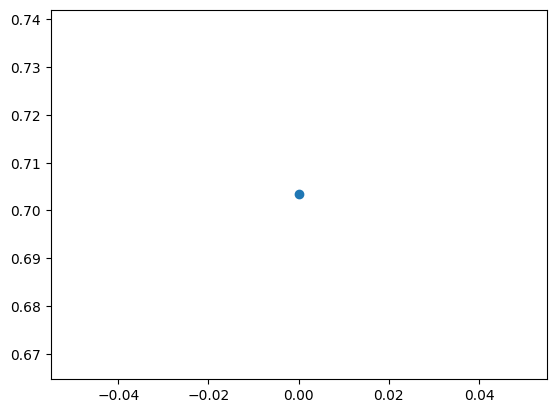

In [ ]:
import matplotlib.pyplot as plt
print(loss)
plt.plot(list(range(1)), loss[1:],linestyle="",marker="o")


In [ ]:
accs20241028 = acclst

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore error 'model' is not defined

torch.cuda.empty_cache()
gc.collect()
#!nvidia-smi #prints out stats

del model

## Result Analysis

In [ ]:
# @title TwinTransformerGetBadResults Definition
def TwinTransformerGetBadResults(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=1, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    falsePositives = []
    falseNegatives = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            if preds[0].int() != label.int():
              if preds[0].int() == 1:
                falsePositives.append(data)
              if preds[0].int() == 0:
                falseNegatives.append(data)

            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy, falsePositives, falseNegatives

In [ ]:
model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))



<ipython-input-49-a8faf42b97f2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


<All keys matched successfully>

In [ ]:
p,a,fp,fn = TwinTransformerGetBadResults(model,dataTest,labelTest)

In [ ]:
_, confusion = OutputEval(p, labelTest, 'TwinTwinTransformer')

       -------------------------------------------
       method           :  TwinTwinTransformer
       accuracy  (ACC)  :  83.333%
       precision (P)    :  76.322%
       recall    (R)    :  70.037%
       F1 score  (F1)   :  0.730
       fall-out  (FPR)  :  10.339%
       miss rate (FNR)  :  29.963%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4622 (TN)   735  (FN)
                   Pos     533  (FP)   1718 (TP)
       -------------------------------------------


In [ ]:
fdata = np.concatenate((fp,fn)).squeeze()
flabels = np.concatenate((np.zeros((len(fp),1)),np.ones((len(fn),1))))
fdata.shape

(1268, 800, 13)

In [ ]:
  modelV, acc = TwinTransformerTrain(fdata, flabels, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  acclst = acc
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformerV')

[INFO] <TwinTransformer> ModelType: TwinTransformer.
[Epoch 001] loss: 3.32, train acc: 28.391%, valid acc: 67.758%, test acc: 67.758%.
[Epoch 002] loss: 0.324, train acc: 91.719%, valid acc: 32.242%, test acc: 32.242%.


KeyboardInterrupt: 

In [ ]:
def TransformPatch2Imgs(sequence): #sequence 800x5
  bf = sequence[:,0:5]
  b = np.zeros((800,5))
  for i in range(len(bf)):
    itemValue = bf[i][0]
    itemChannel = np.argmax(bf[i][1:6])
    b[i][itemChannel] = itemValue
  b = b.reshape((20,40,5))
  af = sequence[:,6:]
  a = np.zeros((800,5))
  for i in range(len(af)):
    itemValue = af[i][0]
    itemChannel = np.argmax(af[i][1:6])
    a[i][itemChannel] = itemValue
  a = a.reshape((20,40,5))

  c = np.zeros((40,40,5))
  iter = 0
  for i in range(0,20):
    c[iter]=b[i]
    c[iter+1]=a[i]
    iter = iter +2

  return b,a,c #20x40x5 #h,w,c


In [ ]:
before, after, concatenated = TransformPatch2Imgs(fp[0])

# Combination of Model2 and Model5

In [ ]:
# @title TwinCNN (nn.model)
class TwinCNN(nn.Module):
  '''
  TwinCNN : convert a patch data into a predicted label.
  '''
  def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
    '''
    define each layer in the network model.
    :param preWTwin: tensor pre-trained weights for embedding layer for twin.
    :param preWMsg: tensor pre-trained weights for embedding layer for msg.
    :param hidSizTwin: node number in the hidden layer for twin.
    :param hidSizMsg: node number in the hidden layer for msg.
    :param hidLayTwin: number of hidden layer for twin.
    :param hidLayMsg: number of hidden layer for msg.
    '''

    super(TwinCNN, self).__init__()

    class_num = 2

    self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
    if(preWTwin is not None):
      self.embedTwin.load_state_dict({'weight': preWTwin})
    self.embedTwin.weight.requires_grad = True


    self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
    if(preWMsg is not None):
      self.embedMsg.load_state_dict({'weight': preWMsg})
    self.embedMsg.weight.requires_grad = True


    self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, 100, (k, 128), padding=(k-2,0))
            for k in [3,4,5]])

    self.norm = nn.LayerNorm(normalized_shape=300)
    self.dropout = nn.Dropout(0.2)
    self.fcB = nn.Linear(300, 150)
    self.fcA = nn.Linear(300, 150)
    self.fcM = nn.Linear(300, 150)
    self.fc = nn.Linear(450, 150)
    self.fc2 = nn.Linear(150,2)

    self.sig = nn.Sigmoid()

  def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer ##Source: https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = nn.functional.relu(conv(x)).squeeze(3)

        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

  def forward(self, x):
    '''
    convert inputs to predictions.
    :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
    :return: self.softmax(final_out) - predictions.
    [[0.3, 0.7], [0.2, 0.8], ...]
    '''
    #input b,800,13
    batch_size = x.shape[0]

    xTwinB = x[:, :_TwinMaxLen_, :6]
    embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) #b,800,128
    embedsTwinB = embedsTwinB.unsqueeze(1)


    xTwinA = x[:, :_TwinMaxLen_, 6:-1]
    embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) #b,800,128
    embedsTwinA = embedsTwinA.unsqueeze(1)

    xMsg = x[:, :_MsgMaxLen_, -1]
    embedsMsg = self.embedMsg(xMsg) # b,200,128
    embedsMsg = embedsMsg.unsqueeze(1)

    conv_resultsB = [self.conv_and_pool(embedsTwinB, conv) for conv in self.convs_1d]
    conv_resultsA = [self.conv_and_pool(embedsTwinA, conv) for conv in self.convs_1d]
    conv_resultsM = [self.conv_and_pool(embedsMsg, conv) for conv in self.convs_1d]


    # concatenate results and add dropout
    xB = torch.cat(conv_resultsB, 1)
    xA = torch.cat(conv_resultsA, 1)
    xM = torch.cat(conv_resultsM, 1)

    xB = self.fcB(xB)
    xA = self.fcA(xA)
    xM = self.fcM(xM)

    x = torch.cat((xB,xA,xM),1)

    return x

    #x = self.dropout(x)

    # final logit
    #x = self.fc(x)
    #logit = self.fc2(x)



    # sigmoid-activated --> a class score
    #return logit

In [ ]:
# @title TwinTransformer (nn.model)
class TwinTransformer(nn.Module):
    '''
    TwinTransformer : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinTransformer, self).__init__()
        # parameters.
        class_num = 2
        # twin.
        #vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True

        self.embedPositionTwin  = nn.Parameter(data=torch.randn(1, _TwinMaxLen_, emDimTwin),requires_grad=True)
        self.embedPositionMsg  = nn.Parameter(data=torch.randn(1, _MsgMaxLen_, emDimMsg),requires_grad=True)

        #vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True

        #lerneable parameters
        self.embedClassB = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassA = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassM = nn.Parameter(data=torch.randn(1, 1, emDimMsg),requires_grad=True)

        self.transformerTwinB = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.transformerTwinA = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=None, enable_nested_tensor=True, mask_check=False)

        self.transformerMsg = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimMsg,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=emDimTwin+emDimTwin+emDimMsg,
                      out_features=emDimTwin+emDimTwin+emDimMsg),
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Linear(in_features= emDimTwin+emDimTwin+emDimMsg,
                      out_features=class_num)
        )

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''
        batch_size = x.shape[0]
    # twin 1.
        #print("begin")
        xTwinB = x[:, :_TwinMaxLen_-1, :6]
        embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) # b,799,128
        featuresB = xTwinB[:, :, 1:] # b,799,5
        classTokenB = self.embedClassB.expand(batch_size,-1,-1).to(device)
        xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
        xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
        xb = self.embedPositionTwin + xb
        xb = self.transformerTwinB(xb) # b,800,128

    # twin 2.
        xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
        embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) # b,799,128
        featuresA = xTwinA[:, :, 1:] # b,799,5
        classTokenA = self.embedClassA.expand(batch_size,-1,-1).to(device)
        xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
        xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
        xa = self.embedPositionTwin + xa
        xa = self.transformerTwinA(xa) # b,800,128

    # msg.
        xMsg = x[:, :_MsgMaxLen_-1, -1]
        embedsMsg = self.embedMsg(xMsg) # b,199,128
        classTokenM = self.embedClassM.expand(batch_size,-1,-1).to(device)
        xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
        xm = self.embedPositionMsg + xm
        xm = self.transformerMsg(xm) # b,200,128

    # common.
        concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0]), dim=1) # b,128+128+128

        return concatenated

        #x = self.classifier(concatenated)
        #return x



In [ ]:
#@title TwinComb (nn.model)

import torch
import torch.nn as nn

class TwinComb(nn.Module):
    def __init__(self):
        super(TwinComb, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model

        tot = 150+150+150+128+128+128
        self.combined_fc = nn.Sequential(
            #nn.Linear(tot, (tot)),
            #nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(tot,2)# Adjust the final output size as needed
        )

        # # Example: assuming each outputs 128-dim vectors, you combine them and classify
        # self.combined_fc = nn.Sequential(
        #     nn.Linear(300+300+300+128+128+128, 300+300+300+128+128+128),
        #     nn.ReLU(),
        #     nn.Linear(300+300+300+128+128+128, (300+300+300+128+128+128)/2),
        #     nn.ReLU(),
        #     nn.Linear((300+300+300+128+128+128)/2, (300+300+300+128+128+128)/8),  # Adjust the final output size as needed
        #     nn.ReLU(),
        #     nn.Linear((300+300+300+128+128+128)/8, 2),
        # )

    def forward(self, x):
        #x1 = self.cnn(x) # b, 300+300+300
        #x2 = self.transformer(x) # b, 128+128+128
        #combined = torch.cat((x1, x2), dim=1)
        #print
        #out = self.combined_fc(combined)
        out = self.combined_fc(x)
        return out


# class TwinComb(nn.Module):
#     def __init__(self):
#         super(TwinComb, self).__init__()
#         input_dim = 3*150 + 3*128  # 3 CNN features, 3 Transformer features
#         hidden_dim = 512

#         self.combined_fc = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(hidden_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(256, 2)  # 2 classes
#         )

#     def forward(self, x):
#         return self.combined_fc(x)


In [ ]:
import time
from tqdm import tqdm

# @title TwinCombTrain Definition
def TwinCombTrain(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None, trd=None, ted=None, tvd=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''
    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)


    cnn_model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    transformer_model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)


    # Step 1: Load the pre-trained models
    cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
    transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))

    # Step 2: Freeze their parameters
    for param in cnn_model.parameters():
        param.requires_grad = False

    for param in transformer_model.parameters():
        param.requires_grad = False

    # Put models in eval mode for feature extraction
    cnn_model.eval()
    transformer_model.eval()

    if trd is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTrain.size(0), batchsize), desc="Extracting features"):
              batch_x = xTrain[i:i+batchsize].to(device)
              batch_y = yTrain[i:i+batchsize]

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTrain_combined = torch.cat(all_features, dim=0).float()
          yTrain_combined = torch.cat(all_labels, dim=0)

      # Now create the TensorDataset with precomputed features
      train = torchdata.TensorDataset(xTrain_combined, yTrain_combined)
      trd = train
    else:
      train=trd

    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        cnn_model.eval()
        transformer_model.eval()
        if ted is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting features Test dataset"):
                  batch_x = xTest[i:i+batchsize].to(device)
                  batch_y = yTest[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xTest_combined = torch.cat(all_features, dim=0).float()
              yTest_combined = torch.cat(all_labels, dim=0)
              test = torchdata.TensorDataset(xTest_combined, yTest_combined)
              ted = test
        else:
          test = ted
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    if (True):
        valid = torchdata.TensorDataset(xValid, yValid)
        cnn_model.eval()
        transformer_model.eval()
        if tvd is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xValid.size(0), batchsize), desc="Extracting features Valid dataset"):
                  batch_x = xValid[i:i+batchsize].to(device)
                  batch_y = yValid[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xValid_combined = torch.cat(all_features, dim=0).float()
              yValid_combined = torch.cat(all_labels, dim=0)
              valid = torchdata.TensorDataset(xValid_combined, yValid_combined)
              tvd = valid
        else:
          valid = tvd
        validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)

    model = TwinComb()
    model.to(device)
    print('[INFO] <TwinCNN> ModelType: TwinComb.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=1e-5)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    execution_times = []
    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 10 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat.shape)
            #print("Label",label.shape)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)

            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    #torch.cuda.empty_cache()
            gc.collect()
            #torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinComb.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinComb model. (Best model: ' + tempPath + '/model_TwinComb.pth)')

    return model, accList, execution_times, accL, validAccL, lossL, cnn_model, transformer_model, trd, ted, tvd


In [ ]:
# @title TwinCombTest Definition
def TwinCombTest(model, cnn_model, transformer_model, dTest, lTest, batchsize=64,ted=None):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    cnn_model.eval()
    transformer_model.eval()

    if ted is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting Test features in Eval"):
              batch_x = xTest[i:i+batchsize].to(device)
              batch_y = yTest[i:i+batchsize].to(device)

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTest_combined = torch.cat(all_features, dim=0).float()
          yTest_combined = torch.cat(all_labels, dim=0)

      test = torchdata.TensorDataset(xTest_combined, yTest_combined)
      ted = test
    else:
      test = ted
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
    gc.collect()
    #torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

In [ ]:
# @title RunTransformer

def RunComb(trd,ted,tvd):
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_RunComb.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinCNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_RunComb.pth'))
      return model
  else:
      model, acc, execution_times, acc, accTrain, loss, cmodel, tmodel, rtrd, rted, rtvd = TwinCombTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest,trd=trd,ted=ted,tvd=tvd)

      # TwinRNNTest
      predictions, accuracy = TwinCombTest(model, cmodel, tmodel, dataTest, labelTest, batchsize=_TRnnBatchSz_,ted=ted)
      _, confusion = OutputEval(predictions, labelTest, 'RunComb')
      return model,execution_times, acc,accTrain,loss, cmodel, tmodel, rtrd, rted, rtvd

# Analysis

In [ ]:
del model

NameError: name 'model' is not defined

In [ ]:
_trd=None
_ted=None
_tvd=None

In [ ]:
model,executionTimes,accLst,accTrain,loss,_cmodel,_tmodel,_trd,_ted,_tvd=RunComb(_trd,_ted,_ted)

<ipython-input-572-acad9b421699>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.173, train acc: 93.688%, valid acc: 84.516%, test acc: 84.516%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 002] loss: 0.0664, train acc: 98.285%, valid acc: 84.332%, test acc: 84.332%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[

<ipython-input-572-acad9b421699>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))


Execution Time = 0.02532153611537069 seconds
       -------------------------------------------
       method           :  RunComb
       accuracy  (ACC)  :  84.516%
       precision (P)    :  76.619%
       recall    (R)    :  75.694%
       F1 score  (F1)   :  0.762
       fall-out  (FPR)  :  11.204%
       miss rate (FNR)  :  24.306%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4549 (TN)   604  (FN)
                   Pos     574  (FP)   1881 (TP)
       -------------------------------------------


In [ ]:
def LoadModel():
  m = model = TwinComb()
  m.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))
  return m

In [ ]:
type(_ted)

torch.utils.data.dataset.TensorDataset

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.3/992.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
import shap
import torch
import numpy as np

model.eval()
device = next(model.parameters()).device

background = torch.stack([_trd[i][0] for i in range(50)]).to(device)
test_inputs = torch.stack([_ted[i][0] for i in range(100)]).to(device)

# background = torch.stack([_trd[i][0] for i in range(10)]).to(device)
# test_inputs = torch.stack([_ted[i][0] for i in range(10)]).to(device)

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_inputs)

# shap_values shape: (10, 834, 2) — [samples, features, outputs]
shap_array_class0 = shap_values[:, :, 0]  # Class 0
shap_array_class1 = shap_values[:, :, 1]  # Class 1

cnn_contrib_c1 = np.abs(shap_array_class1[:, :384]).mean()
trans_contrib_c1 = np.abs(shap_array_class1[:, 384:]).mean()

cnn_contrib_c0 = np.abs(shap_array_class0[:, :384]).mean()
trans_contrib_c0 = np.abs(shap_array_class0[:, 384:]).mean()

print(f"Class 0 CNN SHAP contrib:        {cnn_contrib_c0:.4f}")
print(f"Class 0 Transformer SHAP contrib: {trans_contrib_c0:.4f}")
print(f"Class 1 CNN SHAP contrib:        {cnn_contrib_c1:.4f}")
print(f"Class 1 Transformer SHAP contrib: {trans_contrib_c1:.4f}")

Class 0 CNN SHAP contrib:        0.0318
Class 0 Transformer SHAP contrib: 0.0255
Class 1 CNN SHAP contrib:        0.0319
Class 1 Transformer SHAP contrib: 0.0255


In [ ]:
import numpy as np

# shap_array_class1 shape: [samples, features]
mean_abs_shap = np.abs(shap_array_class1).mean(axis=0)  # mean over samples per feature

dead_inputs = np.where(mean_abs_shap < 1e-4)[0]  # threshold near zero
print(f"Features with near-zero contribution: {dead_inputs}")


Features with near-zero contribution: []


In [ ]:
shap_array_class1.shape

(100, 834)

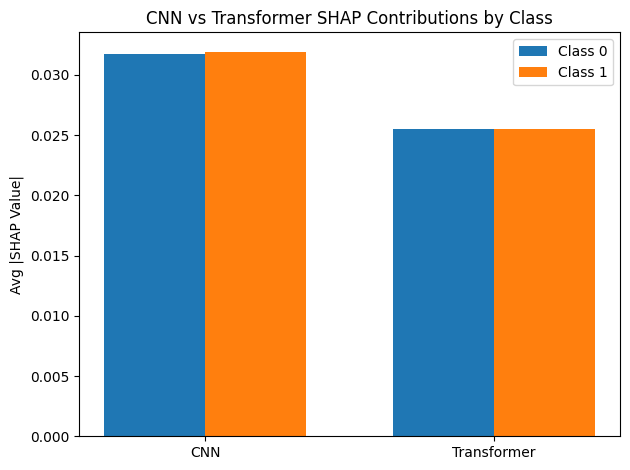

In [ ]:
import matplotlib.pyplot as plt

labels = ['CNN', 'Transformer']
class0_vals = [cnn_contrib_c0, trans_contrib_c0]
class1_vals = [cnn_contrib_c1, trans_contrib_c1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, class0_vals, width, label='Class 0')
bar2 = ax.bar(x + width/2, class1_vals, width, label='Class 1')

ax.set_ylabel('Avg |SHAP Value|')
ax.set_title('CNN vs Transformer SHAP Contributions by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)  # shape: [n_features]
sorted_indices = np.argsort(mean_abs_shap)  # ascending = least important first
prune_ratio = 0.1  # 10%
k = int(len(sorted_indices) * prune_ratio)
features_to_keep = np.sort(sorted_indices[k:])  # keep the most important ones


In [ ]:
_trdeX = _trd.tensors[0]
_trdeY = _trd.tensors[1]
_tedeX = _ted.tensors[0]
_tedeY = _ted.tensors[1]


In [ ]:
features_to_keep

array([  0,   1,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134,
       135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [ ]:
xTrain_pruned = _trdeX[:, features_to_keep]
xTest_pruned = _tedeX[:, features_to_keep]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(xTrain_pruned, _trdeY)
yPred = clf.predict(xTest_pruned)
print("Accuracy after SHAP pruning:", accuracy_score(_tedeY, yPred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy after SHAP pruning: 0.8289957939011566


In [ ]:
import matplotlib.pyplot as plt

def plot_weight_histograms(model, layer_names=None, bins=100, title=""):
    for name, param in model.named_parameters():
        if param.requires_grad:
            if (layer_names is None) or any(lname in name for lname in layer_names):
                weights = param.data.cpu().numpy().flatten()
                plt.hist(weights, bins=bins, alpha=0.7, label=name)

    plt.title(f"Weight Distributions {title}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
model

TwinComb(
  (combined_fc): Sequential(
    (0): Linear(in_features=834, out_features=834, bias=True)
    (1): ReLU()
    (2): Linear(in_features=834, out_features=2, bias=True)
  )
)

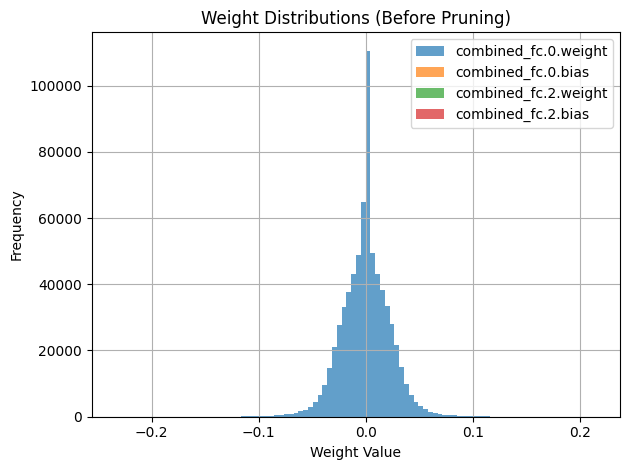

In [ ]:
plot_weight_histograms(model, layer_names=["combined_fc"], title="(Before Pruning)")


In [ ]:
import torch.nn.utils.prune as prune

# Example: Prune 30% of weights in each Linear layer
for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.3)


In [ ]:
for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')




In [ ]:
def Test(ted):
  if(twinPreWeights is not None):
    preWTwin = torch.from_numpy(twinPreWeights)
  if(msgPreWeights is not None):
    preWMsg = torch.from_numpy(msgPreWeights)
  cnn_model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
  transformer_model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
  transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))

  # Step 2: Freeze their parameters
  for param in cnn_model.parameters():
      param.requires_grad = False

  for param in transformer_model.parameters():
      param.requires_grad = False
  predictions, accuracy = TwinCombTest(model, cnn_model, transformer_model, dataTest, labelTest, batchsize=_TRnnBatchSz_,ted=ted)
  _, confusion = OutputEval(predictions, labelTest, 'RunComb')
  return predictions

In [ ]:
Test(_ted)

<ipython-input-368-d8910aba0011>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-inp

Execution Time = 0.14398604887537658 seconds
       -------------------------------------------
       method           :  RunComb
       accuracy  (ACC)  :  84.188%
       precision (P)    :  80.350%
       recall    (R)    :  68.290%
       F1 score  (F1)   :  0.738
       fall-out  (FPR)  :  8.101%
       miss rate (FNR)  :  31.710%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4708 (TN)   788  (FN)
                   Pos     415  (FP)   1697 (TP)
       -------------------------------------------


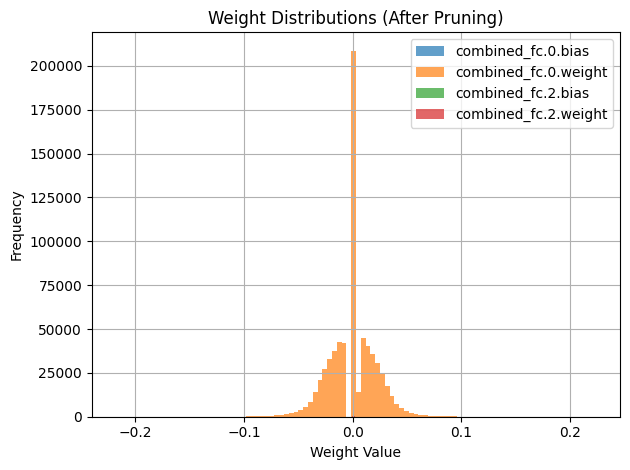

In [ ]:
plot_weight_histograms(model, layer_names=["combined_fc"], title="(After Pruning)")


In [ ]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn

# Define the custom pruning class
class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = 'unstructured'

    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def compute_mask(self, t, default_mask):
        # Mask out weights with abs(val) < threshold
        return torch.where(torch.abs(t) < self.threshold, torch.zeros_like(t), torch.ones_like(t))

    @classmethod
    def apply(cls, module, name, threshold):
        return super().apply(module, name, threshold=threshold)

# Convenience function to prune
def prune_by_threshold(module, name, threshold):
    ThresholdPruning.apply(module, name, threshold)
    return module

for name, module in model.combined_fc.named_modules():
    if isinstance(module, nn.Linear):
        prune_by_threshold(module, 'weight', threshold=1e-2)
        prune.remove(module, 'weight')  # Make pruning permanent if needed

In [ ]:
model = LoadModel()

<ipython-input-371-2f6577caebde>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))


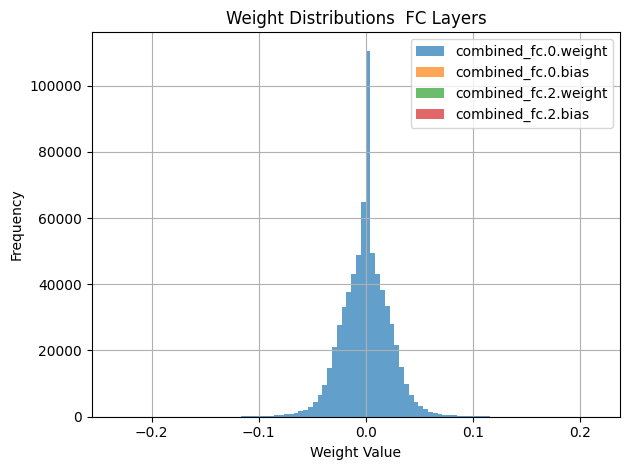

In [ ]:
plot_weight_histograms(model, layer_names=["combined_fc"],title=" FC Layers")


In [ ]:
for name, module in model.combined_fc.named_modules():
    if isinstance(module, nn.Linear):
        weights = module.weight.data
        print(f"{name}: {weights.numel()} total, {torch.sum(weights == 0).item()} zeros ({(weights == 0).float().mean().item() * 100:.2f}%)")


0: 695556 total, 0 zeros (0.00%)
2: 1668 total, 0 zeros (0.00%)


In [ ]:
import time
from tqdm import tqdm

# @title TwinCombTrainExtended Definition
def TwinCombTrainExtended(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None, trd=None, ted=None, model=None, epochs=1):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)


    cnn_model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    transformer_model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)


    # Step 1: Load the pre-trained models
    cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
    transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))

    # Step 2: Freeze their parameters
    for param in cnn_model.parameters():
        param.requires_grad = False

    for param in transformer_model.parameters():
        param.requires_grad = False

    # Put models in eval mode for feature extraction
    cnn_model.eval()
    transformer_model.eval()

    if trd is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTrain.size(0), batchsize), desc="Extracting features"):
              batch_x = xTrain[i:i+batchsize].to(device)
              batch_y = yTrain[i:i+batchsize]

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTrain_combined = torch.cat(all_features, dim=0).float()
          yTrain_combined = torch.cat(all_labels, dim=0)

      # Now create the TensorDataset with precomputed features
      train = torchdata.TensorDataset(xTrain_combined, yTrain_combined)
      trd = train
    else:
      train=trd

    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        cnn_model.eval()
        transformer_model.eval()
        if ted is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting features Test dataset"):
                  batch_x = xTest[i:i+batchsize].to(device)
                  batch_y = yTest[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xTest_combined = torch.cat(all_features, dim=0).float()
              yTest_combined = torch.cat(all_labels, dim=0)
              test = torchdata.TensorDataset(xTest_combined, yTest_combined)
              ted = test
        else:
          test = ted
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)
    validloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    model.to(device)
    print('[INFO] <TwinCNN> ModelType: TwinComb.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=1e-5)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    execution_times = []
    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []

    for epoch in range(epochs):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 10 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat)
            #print("Label",label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)

            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    #torch.cuda.empty_cache()
            gc.collect()
            #torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinCombExt.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinCombExt.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinComb model. (Best model: ' + tempPath + '/model_TwinCombExt.pth)')

    return model, accList, execution_times, accL, validAccL, lossL, cnn_model, transformer_model, trd, ted


In [ ]:
model2, acc, execution_times, acc, accTrain, loss, cmodel, tmodel, rtrd, rted = TwinCombTrainExtended(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                      batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest,trd=_trd,ted=_ted,model=model,epochs=1)

<ipython-input-327-ab5da5874c6f>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.0192, train acc: 99.294%, valid acc: 83.912%, test acc: 83.912%.
Total execution time 1.508990
[INFO] <TwinRNNTrain> Finish training TwinComb model. (Best model: .//temp//model_TwinCombExt.pth)


<ipython-input-327-ab5da5874c6f>:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinCombExt.pth'))


In [ ]:
model2, acc, execution_times, acc, accTrain, loss, cmodel, tmodel, rtrd, rted = TwinCombTrainExtended(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                      batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest,trd=_trd,ted=_ted,model=model2,epochs=5)

<ipython-input-327-ab5da5874c6f>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.018, train acc: 99.356%, valid acc: 83.623%, test acc: 83.623%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 002] loss: 0.0187, train acc: 99.274%, valid acc: 83.583%, test acc: 83.583%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[

<ipython-input-327-ab5da5874c6f>:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinCombExt.pth'))


In [ ]:
model.eval()
with torch.no_grad():
    probs = torch.softmax(model(_tedeX), dim=1)[:, 1].cpu().numpy()  # Probabilities for class 1

# Now tune threshold with sklearn
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(_tedeY.cpu().numpy(), probs)


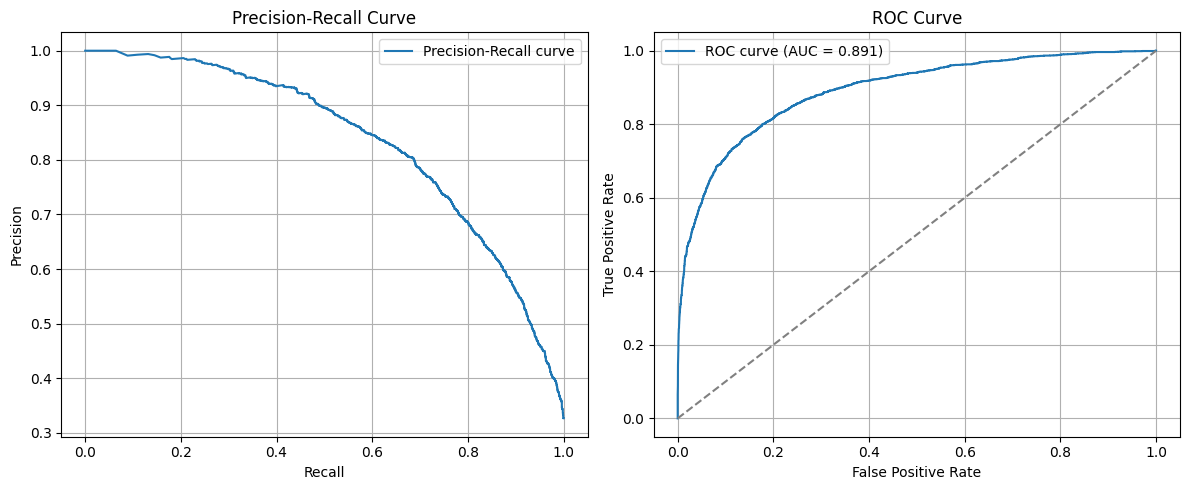

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Ensure numpy arrays
y_true = _tedeY.cpu().numpy() if torch.is_tensor(_tedeY) else _tedeY
y_scores = probs  # predicted probabilities for positive class

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Plot Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
pred_labels=Test(_ted)

<ipython-input-429-fa9e2f13671e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-inp

Execution Time = 0.09007329598534852 seconds
       -------------------------------------------
       method           :  RunComb
       accuracy  (ACC)  :  84.122%
       precision (P)    :  79.767%
       recall    (R)    :  68.853%
       F1 score  (F1)   :  0.739
       fall-out  (FPR)  :  8.472%
       miss rate (FNR)  :  31.147%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4689 (TN)   774  (FN)
                   Pos     434  (FP)   1711 (TP)
       -------------------------------------------


In [ ]:
pred_labels=np.array(pred_labels)

(7608, 1)

In [ ]:
# Assuming y_true and y_pred are tensors or arrays
# Ensure both labels are 1D tensors
true_labels = torch.tensor(labelTest).view(-1)      # shape [N]
pred_labels = torch.tensor(pred_labels).view(-1)           # shape [N]

# Get False Negatives: true label = 1, predicted = 0
fn_mask = (true_labels == 1) & (pred_labels == 0)   # shape [N]

# Apply mask to inputs
fn_inputs = _tedeX[fn_mask]                         # shape [num_FN, 834]

(tensor(0), [0])

In [ ]:
explainer = shap.DeepExplainer(model, background)
fn_shap_values = explainer.shap_values(fn_inputs)


In [ ]:
fn_shap_class1 = fn_shap_values[:, :, 1]  # [samples, features]


In [ ]:
mean_shap_fn = np.mean(np.abs(fn_shap_class1), axis=0)


In [ ]:
# If your first 384 features are from CNN and the rest from Transformer:
feature_names = [f"CNN_{i}" for i in range(384)] + [f"TRANS_{i}" for i in range(450)]


<ipython-input-448-e7d1249ce229>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(fn_shap_class1, fn_inputs.cpu().numpy(), feature_names=feature_names)


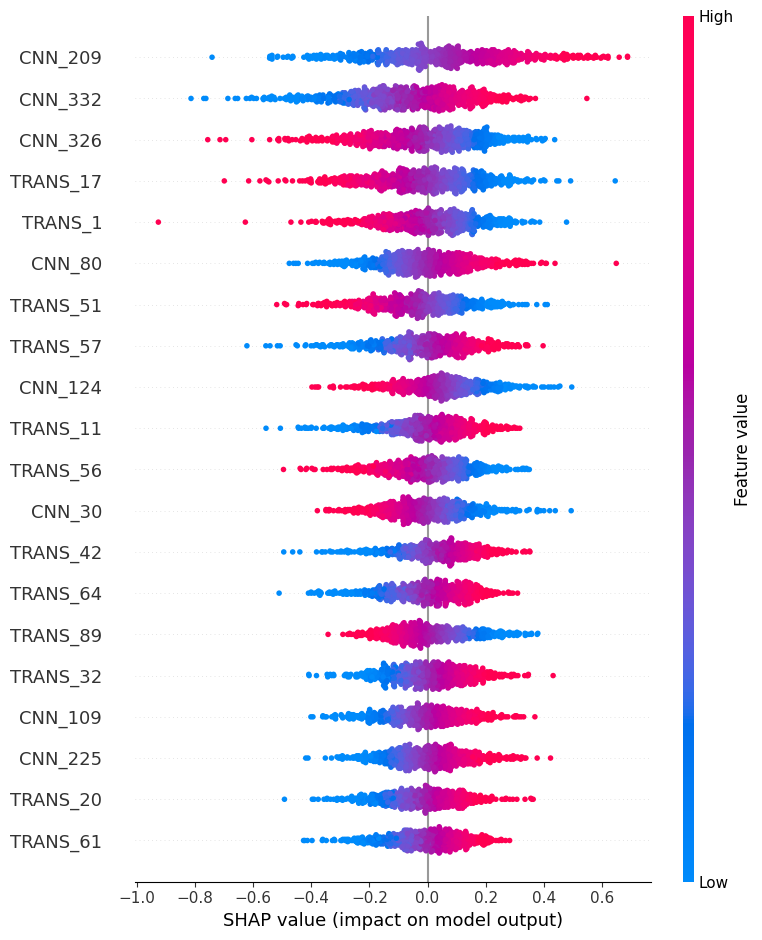

In [ ]:
shap.summary_plot(fn_shap_class1, fn_inputs.cpu().numpy(), feature_names=feature_names)


In [ ]:
# Raw names from SHAP summary (top impactful features)
top_features = [
    'CNN_209', 'CNN_332', 'CNN_326', 'TRANS_17', 'TRANS_1'
]

# Convert to correct indices in input tensor
feature_indices_to_zero = []
for feat in top_features:
    prefix, idx = feat.split('_')
    idx = int(idx)
    if prefix == 'CNN':
        feature_indices_to_zero.append(idx)
    elif prefix == 'TRANS':
        feature_indices_to_zero.append(384 + idx)


In [ ]:
# Convert to numpy if needed
fn_inputs_modified = fn_inputs.clone()

fn_inputs_modified[:, feature_indices_to_zero] = 0

# Run through model again
model.eval()
with torch.no_grad():
    outputs = model(fn_inputs_modified)
    preds = outputs.argmax(dim=1)

# Compare against original predictions


In [ ]:
corrected_fns = (preds == 1).sum().item()
total_fns = fn_inputs.shape[0]
print(f"Corrected FNs: {corrected_fns} / {total_fns} ({100 * corrected_fns / total_fns:.2f}%)")

Corrected FNs: 4 / 774 (0.52%)


In [ ]:
import torch

# Original predictions
y_true_tensor = torch.tensor(labelTest).squeeze()
y_pred_orig = _tedeY.squeeze()
x_orig = _tedeX.clone()

# Identify TP indices (originally predicted 1, and ground truth is 1)
tp_mask = (y_true_tensor == 1) & (y_pred_orig == 1)
tp_inputs = x_orig[tp_mask]
tp_labels = y_true_tensor[tp_mask]

# Zero out selected features
tp_inputs_modified = tp_inputs.clone()
tp_inputs_modified[:, feature_indices_to_zero] = 0

# Run model on modified TPs
model.eval()
with torch.no_grad():
    outputs = model(tp_inputs_modified)
    preds_modified = torch.argmax(outputs, dim=1)

# Count how many TPs turned into something else (e.g. predicted 0)
tp_flipped_to_fn = ((tp_labels == 1) & (preds_modified == 0)).sum().item()

print(f"Original TP count: {tp_mask.sum().item()}")
print(f"TPs flipped to FN after feature zeroing: {tp_flipped_to_fn}")


Original TP count: 2485
TPs flipped to FN after feature zeroing: 808


# Kfold


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

def TwinCombTrain_KFold(dTrain, lTrain, preWTwin=None, preWMsg=None, batchsize=256, learnRate=0.001, k=5, dTest=None, lTest=None):
    """
    K-Fold cross-validation wrapper for TwinCombTrain.

    :param dTrain: Full training data
    :param lTrain: Full training labels
    :param preWTwin: Pretrained twin weights
    :param preWMsg: Pretrained msg weights
    :param batchsize: Batch size
    :param learnRate: Learning rate
    :param k: Number of folds
    :param dTest: Optional test data (used in each fold if provided)
    :param lTest: Optional test labels
    :return: List of models and aggregated metrics
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_fold_metrics = []
    all_models = []

    for fold_idx, (train_index, val_index) in enumerate(kf.split(dTrain)):
        print(f"\n[INFO] Starting Fold {fold_idx+1}/{k}")

        fold_dTrain = dTrain[train_index]
        fold_lTrain = lTrain[train_index]
        fold_dValid = dTrain[val_index]
        fold_lValid = lTrain[val_index]

        print(f"{fold_dTrain.shape} / {fold_lTrain.shape}")

        model, accList, execution_times, accL, validAccL, lossL, cnn_model, transformer_model, trd, ted,tvd = TwinCombTrain(
            fold_dTrain, fold_lTrain, fold_dValid, fold_lValid,
            preWTwin=preWTwin, preWMsg=preWMsg, batchsize=batchsize,
            learnRate=learnRate, dTest=dTest, lTest=lTest,
            trd=torchdata.TensorDataset(torch.tensor(fold_dTrain),torch.tensor(fold_lTrain)),
            ted=torchdata.TensorDataset(torch.tensor(dTest),torch.tensor(lTest)),
            tvd=torchdata.TensorDataset(torch.tensor(fold_dValid),torch.tensor(fold_lValid))
        )

        all_models.append(model)
        all_fold_metrics.append({
            'accList': accList,
            'accL': accL,
            'validAccL': validAccL,
            'lossL': lossL,
            'execution_times': execution_times
        })

    return all_models, all_fold_metrics


In [ ]:
_trdeX.shape

torch.Size([30433, 834])

In [ ]:
models, metrics = TwinCombTrain_KFold(_trdeX.numpy(), _trdeY.numpy(), preWTwin=twinPreWeights, preWMsg=msgPreWeights, k=5, dTest=_tedeX.numpy(),lTest=_tedeY.numpy())



[INFO] Starting Fold 1/5
(24346, 834) / (24346, 1)


<ipython-input-525-9e12ed401f75>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 001] loss: 0.0626, train acc: 98.000%, valid acc: 98.899%, test acc: 83.228%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 002] loss: 0.0316, train acc: 98.907%, valid acc: 98.899%, test acc: 82.926%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 003] loss: 0.0296, train acc: 98.940%, valid acc: 98.866%, test acc: 82.965%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 9

<ipython-input-525-9e12ed401f75>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))
<ipython-input-525-9e

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 001] loss: 0.0616, train acc: 98.012%, valid acc: 99.031%, test acc: 83.675%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 002] loss: 0.0322, train acc: 98.883%, valid acc: 98.998%, test acc: 83.294%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 003] loss: 0.03, train acc: 98.953%, valid acc: 98.998%, test acc: 83.373%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96


<ipython-input-525-9e12ed401f75>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))
<ipython-input-525-9e

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 001] loss: 0.0571, train acc: 97.807%, valid acc: 98.866%, test acc: 83.412%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 002] loss: 0.0316, train acc: 98.953%, valid acc: 98.801%, test acc: 83.228%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 003] loss: 0.0296, train acc: 99.039%, valid acc: 98.735%, test acc: 83.189%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 9

<ipython-input-525-9e12ed401f75>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))
<ipython-input-525-9e

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 001] loss: 0.0572, train acc: 98.000%, valid acc: 98.784%, test acc: 83.268%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 002] loss: 0.03, train acc: 98.932%, valid acc: 98.801%, test acc: 83.136%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 003] loss: 0.0282, train acc: 99.006%, valid acc: 98.784%, test acc: 83.162%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96


<ipython-input-525-9e12ed401f75>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))


(24347, 834) / (24347, 1)


<ipython-input-525-9e12ed401f75>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 001] loss: 0.0588, train acc: 97.897%, valid acc: 98.833%, test acc: 83.386%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 002] loss: 0.0313, train acc: 98.920%, valid acc: 98.735%, test acc: 83.557%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 96
Iteration 49 out of 96
Iteration 59 out of 96
Iteration 69 out of 96
Iteration 79 out of 96
Iteration 89 out of 96
[Epoch 003] loss: 0.0292, train acc: 99.035%, valid acc: 98.768%, test acc: 83.530%.
Iteration 9 out of 96
Iteration 19 out of 96
Iteration 29 out of 96
Iteration 39 out of 9

<ipython-input-525-9e12ed401f75>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb.pth'))


In [ ]:
models

NameError: name 'models' is not defined

# Combination of models CNN + Transformer + LSTM0

In [ ]:
import time
# @title class TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())

        return featMap
        #return self.softmax(final_out)      # batch_size * class_num

In [ ]:
#@title TwinComb3 (nn.model)

import torch
import torch.nn as nn

class TwinComb3(nn.Module):
    def __init__(self):
        super(TwinComb3, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model
        #CNN+Transformer+LSTM
        tot = 150+150+150+128+128+128+_TRnnHidSiz_ * _TRnnHidLay_ + _MRnnHidSiz_ * _MRnnHidLay_
        self.combined_fc = nn.Sequential(
            nn.Linear(tot, (tot)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(tot,2)# Adjust the final output size as needed
        )

    def forward(self, x):
        out = self.combined_fc(x)
        return out



In [ ]:
#Test for CNN only
class TwinComb3(nn.Module):
    def __init__(self):
        super(TwinComb3, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model
        #CNN+Transformer+LSTM
        tot = 150+150+150
        self.combined_fc = nn.Sequential(
            nn.Linear(tot, (tot)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(tot,2)# Adjust the final output size as needed
        )

    def forward(self, x):
        out = self.combined_fc(x[:,0:150+150+150])
        return out

In [ ]:
#Test for Transformer only
class TwinComb3(nn.Module):
    def __init__(self):
        super(TwinComb3, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model
        #CNN+Transformer+LSTM
        tot = 128+128+128
        self.combined_fc = nn.Sequential(
            nn.Linear(tot, (tot)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(tot,2)# Adjust the final output size as needed
        )

    def forward(self, x):
        out = self.combined_fc(x[:,150+150+150:150+150+150+128+128+128])
        return out

In [ ]:
#Test for LSTM only
class TwinComb3(nn.Module):
    def __init__(self):
        super(TwinComb3, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model
        #CNN+Transformer+LSTM
        tot = _TRnnHidSiz_ * _TRnnHidLay_ + _MRnnHidSiz_ * _MRnnHidLay_
        self.combined_fc = nn.Sequential(
            nn.Linear(tot, (tot)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(tot,2)# Adjust the final output size as needed
        )

    def forward(self, x):
        out = self.combined_fc(x[:,150+150+150+128+128+128:])
        return out

In [ ]:
import time
from tqdm import tqdm

# @title TwinCombTrain3 Definition
def TwinCombTrain3(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None, trd=None, ted=None, tvd=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''
    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)


    cnn_model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    transformer_model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    lstm_model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)

    # Step 1: Load the pre-trained models
    cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
    transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))
    lstm_model.load_state_dict(torch.load("Model0/content/temp/model_TwinRNN.pth"))

    # Step 2: Freeze their parameters
    for param in cnn_model.parameters():
        param.requires_grad = False

    for param in transformer_model.parameters():
        param.requires_grad = False

    # Put models in eval mode for feature extraction
    cnn_model.eval()
    transformer_model.eval()

    if trd is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTrain.size(0), batchsize), desc="Extracting features"):
              batch_x = xTrain[i:i+batchsize].to(device)
              batch_y = yTrain[i:i+batchsize]

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]
              feat_lstm = lstm_model(batch_x)

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTrain_combined = torch.cat(all_features, dim=0).float()
          yTrain_combined = torch.cat(all_labels, dim=0)

      # Now create the TensorDataset with precomputed features
      train = torchdata.TensorDataset(xTrain_combined, yTrain_combined)
      trd = train
    else:
      train=trd

    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        cnn_model.eval()
        transformer_model.eval()
        if ted is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting features Test dataset"):
                  batch_x = xTest[i:i+batchsize].to(device)
                  batch_y = yTest[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]
                  feat_lstm = lstm_model(batch_x)

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xTest_combined = torch.cat(all_features, dim=0).float()
              yTest_combined = torch.cat(all_labels, dim=0)
              test = torchdata.TensorDataset(xTest_combined, yTest_combined)
              ted = test
        else:
          test = ted
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    if (True):
        valid = torchdata.TensorDataset(xValid, yValid)
        cnn_model.eval()
        transformer_model.eval()
        if tvd is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xValid.size(0), batchsize), desc="Extracting features Valid dataset"):
                  batch_x = xValid[i:i+batchsize].to(device)
                  batch_y = yValid[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]
                  feat_lstm = lstm_model(batch_x)

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xValid_combined = torch.cat(all_features, dim=0).float()
              yValid_combined = torch.cat(all_labels, dim=0)
              valid = torchdata.TensorDataset(xValid_combined, yValid_combined)
              tvd = valid
        else:
          valid = tvd
        validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)

    model = TwinComb3()
    model.to(device)
    print('[INFO] <TwinCNN> ModelType: TwinComb.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=1e-5)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    execution_times = []
    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 10 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat.shape)
            #print("Label",label.shape)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)

            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    #torch.cuda.empty_cache()
            gc.collect()
            #torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinComb3.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinComb3.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinComb model. (Best model: ' + tempPath + '/model_TwinComb3.pth)')

    return model, accList, execution_times, accL, validAccL, lossL, cnn_model, transformer_model, lstm_model, trd, ted, tvd


In [ ]:
# @title TwinCombTest3 Definition
def TwinCombTest3(model, cnn_model, transformer_model, lstm_model, dTest, lTest, batchsize=64,ted=None):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    cnn_model.eval()
    transformer_model.eval()
    lstm_model.eval()

    if ted is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting Test features in Eval"):
              batch_x = xTest[i:i+batchsize].to(device)
              batch_y = yTest[i:i+batchsize].to(device)

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]
              feat_lstm = lstm_model(batch_x)

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans,feat_lstm), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTest_combined = torch.cat(all_features, dim=0).float()
          yTest_combined = torch.cat(all_labels, dim=0)

      test = torchdata.TensorDataset(xTest_combined, yTest_combined)
      ted = test
    else:
      test = ted
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
    gc.collect()
    #torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

In [ ]:
_3trd=None
_3ted=None
_3tvd=None

In [ ]:
del model3

In [ ]:
device = 'cpu'


In [ ]:
# @title RunTransformer

def RunComb3(trd,ted,tvd):
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_RunComb3.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinCNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_RunComb3.pth'))
      return model
  else:
      model, acc, execution_times, acc, accTrain, loss, cmodel, tmodel, lmodel, rtrd, rted, rtvd = TwinCombTrain3(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=0.00001, dTest=dataTest, lTest=labelTest,trd=trd,ted=ted,tvd=tvd)

      # TwinRNNTest
      predictions, accuracy = TwinCombTest3(model, cmodel, tmodel, lmodel, dataTest, labelTest, batchsize=_TRnnBatchSz_,ted=rted)
      _, confusion = OutputEval(predictions, labelTest, 'RunComb3')
      return model,execution_times, acc,accTrain,loss, cmodel, tmodel, rtrd, rted, rtvd

In [ ]:
model3,executionTimes,accLst,accTrain,loss,_cmodel,_tmodel,_3trd,_3ted,_3tvd=RunComb3(_3trd,_3ted,_3ted)

<ipython-input-87-e7c0e1833d96>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-inp

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.355, train acc: 88.384%, valid acc: 84.753%, test acc: 84.753%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 002] loss: 0.164, train acc: 95.051%, valid acc: 85.016%, test acc: 85.016%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[E

<ipython-input-87-e7c0e1833d96>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb3.pth'))


Execution Time = 0.06248548615258187 seconds
       -------------------------------------------
       method           :  RunComb3
       accuracy  (ACC)  :  85.068%
       precision (P)    :  77.837%
       recall    (R)    :  75.895%
       F1 score  (F1)   :  0.769
       fall-out  (FPR)  :  10.482%
       miss rate (FNR)  :  24.105%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4586 (TN)   599  (FN)
                   Pos     537  (FP)   1886 (TP)
       -------------------------------------------


# Comb4 (CNN+Transformer+LSTM+Roberta)

## Bert preparations

In [ ]:
!pip install pyarrow==15.0.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 20.0.0
    Uninstalling pyarrow-20.0.0:
      Successfully uninstalled pyarrow-20.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
!pip install datasets

In [ ]:
# @title SplitData
def SplitDataRaw(data, rate=0.2):
    numData = len(data)
    num = math.floor(numData * rate)

    dataList = list(range(numData))
    random.seed(10)
    random.shuffle(dataList)


    # split data.
    dset = data[dataList[0:num]]
    dsetRest = data[dataList[num:]]

    return dset,dsetRest

In [ ]:
from datasets import Dataset

In [ ]:
dataLSTest,dataLSTrain = SplitDataRaw(dataLoaded)

In [ ]:
dsTrainR = Dataset.from_dict({
    "commit": dataLSTrain[:, 0],
    "code": dataLSTrain[:, 1],
    "label": dataLSTrain[:, 2]
})

dsTestR = Dataset.from_dict({
    "commit": dataLSTest[:, 0],
    "code": dataLSTest[:, 1],
    "label": dataLSTest[:, 2]
})

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
def join_and_tokenize(sample):
  joined_text = f"COMMIT: {sample['commit']} CODE: {sample['code']}"
  sample['text'] = joined_text
  return tokenizer(
        sample["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

In [ ]:
#@title Switch depending on deepseek or bert
from transformers import AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
#tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-V2-Lite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dsTrain = dsTrainR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])
dsTest = dsTestR.map(join_and_tokenize, batched=False).remove_columns(["commit","code"])

Map:   0%|          | 0/30433 [00:00<?, ? examples/s]

Map:   0%|          | 0/7608 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

rmodel = AutoModelForSequenceClassification.from_pretrained("./Model9/content/results/checkpoint-952")


In [ ]:
rmodel

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from transformers import RobertaForSequenceClassification

class RobertaWithDenseOutput(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, *args, **kwargs):
        # Call the original forward pass
        outputs = super().forward(*args, **kwargs)

        # Get hidden states from RobertaModel output
        hidden_state = self.roberta(*args, **kwargs)[0]  # shape: (batch_size, seq_len, hidden_dim)

        # Take the representation of the [CLS] token
        cls_output = hidden_state[:, 0, :]  # shape: (batch_size, hidden_dim)

        # Pass through classifier.dense layer to get intermediate output
        dense_output = self.classifier.dense(cls_output)

        return {
            "logits": outputs.logits,
            "dense_output": dense_output  # The output you want
        }


In [ ]:
rmodel = RobertaWithDenseOutput.from_pretrained("./Model9/content/results/checkpoint-952")

inputs = tokenizer("def hello(): print('Hello, world!')", return_tensors="pt")
output = rmodel(**inputs)

#print("Logits:", output["logits"])
#print("Dense layer output:", output["dense_output"])
print(output["dense_output"].shape)

torch.Size([1, 768])


In [ ]:
from tqdm import tqdm


In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dsTrain.remove_columns("text"), batch_size=32)  # Adjust batch_size as needed

from tqdm import tqdm
import torch

rmodel.eval()

transformerXTrain = []

for batch in tqdm(dataloader):
    inputs = {k: v for k, v in batch.items() if k != "label"}
    with torch.no_grad():
        output = rmodel(**inputs)


    # Save logits or intermediate features
    transformerXTrain.append(output)  # Or output.hidden_states if enabled


100%|██████████| 952/952 [9:57:25<00:00, 37.65s/it]


In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dsTest.remove_columns("text"), batch_size=32)  # Adjust batch_size as needed

from tqdm import tqdm
import torch

rmodel.eval()

transformerXTest = []

for batch in tqdm(dataloader):
    inputs = {k: v for k, v in batch.items() if k != "label"}
    with torch.no_grad():
        output = rmodel(**inputs)


    # Save logits or intermediate features
    transformerXTest.append(output)  # Or output.hidden_states if enabled


Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 30433
})

In [ ]:
transformerXTrainCat = []

for batch in transformerXTrain:
  for item in batch['dense_output']:
    transformerXTrainCat.append(item)

In [ ]:
transformerXTest = []
rmodel.eval()
for item in tqdm(dsTest):
    # Convert each item (a dict) to a batch of tensors
    inputs = {
        k: torch.tensor(v).unsqueeze(0)
        for k, v in item.items()
        if k in ["input_ids", "attention_mask", "token_type_ids"]
    }

    with torch.no_grad():
        output = rmodel(**inputs)

    transformerXTest.append(output)

100%|██████████| 7608/7608 [2:47:43<00:00,  1.32s/it]


In [ ]:
transformerXTestCat = []

for batch in transformerXTest:
  for item in batch['dense_output']:
    transformerXTestCat.append(item)

In [ ]:
robertaTrain = np.array(transformerXTrainCat)
robertaTest = np.array(transformerXTestCat)
robertaTrain.shape,robertaTest.shape

((30433, 768), (7608, 768))

In [ ]:
# @title TwinCNN (nn.model)
class TwinCNN(nn.Module):
  '''
  TwinCNN : convert a patch data into a predicted label.
  '''
  def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
    '''
    define each layer in the network model.
    :param preWTwin: tensor pre-trained weights for embedding layer for twin.
    :param preWMsg: tensor pre-trained weights for embedding layer for msg.
    :param hidSizTwin: node number in the hidden layer for twin.
    :param hidSizMsg: node number in the hidden layer for msg.
    :param hidLayTwin: number of hidden layer for twin.
    :param hidLayMsg: number of hidden layer for msg.
    '''

    super(TwinCNN, self).__init__()

    class_num = 2

    self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
    if(preWTwin is not None):
      self.embedTwin.load_state_dict({'weight': preWTwin})
    self.embedTwin.weight.requires_grad = True


    self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
    if(preWMsg is not None):
      self.embedMsg.load_state_dict({'weight': preWMsg})
    self.embedMsg.weight.requires_grad = True


    self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, 100, (k, 128), padding=(k-2,0))
            for k in [3,4,5]])

    self.norm = nn.LayerNorm(normalized_shape=300)
    self.dropout = nn.Dropout(0.2)
    self.fcB = nn.Linear(300, 150)
    self.fcA = nn.Linear(300, 150)
    self.fcM = nn.Linear(300, 150)
    self.fc = nn.Linear(450, 150)
    self.fc2 = nn.Linear(150,2)

    self.sig = nn.Sigmoid()

  def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer ##Source: https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = nn.functional.relu(conv(x)).squeeze(3)

        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

  def forward(self, x):
    '''
    convert inputs to predictions.
    :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
    :return: self.softmax(final_out) - predictions.
    [[0.3, 0.7], [0.2, 0.8], ...]
    '''
    #input b,800,13
    batch_size = x.shape[0]

    xTwinB = x[:, :_TwinMaxLen_, :6]
    embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) #b,800,128
    embedsTwinB = embedsTwinB.unsqueeze(1)


    xTwinA = x[:, :_TwinMaxLen_, 6:-1]
    embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) #b,800,128
    embedsTwinA = embedsTwinA.unsqueeze(1)

    xMsg = x[:, :_MsgMaxLen_, -1]
    embedsMsg = self.embedMsg(xMsg) # b,200,128
    embedsMsg = embedsMsg.unsqueeze(1)

    conv_resultsB = [self.conv_and_pool(embedsTwinB, conv) for conv in self.convs_1d]
    conv_resultsA = [self.conv_and_pool(embedsTwinA, conv) for conv in self.convs_1d]
    conv_resultsM = [self.conv_and_pool(embedsMsg, conv) for conv in self.convs_1d]


    # concatenate results and add dropout
    xB = torch.cat(conv_resultsB, 1)
    xA = torch.cat(conv_resultsA, 1)
    xM = torch.cat(conv_resultsM, 1)

    xB = self.fcB(xB)
    xA = self.fcA(xA)
    xM = self.fcM(xM)

    x = torch.cat((xB,xA,xM),1)

    return x

    #x = self.dropout(x)

    # final logit
    #x = self.fc(x)
    #logit = self.fc2(x)



    # sigmoid-activated --> a class score
    #return logit

In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 20
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 10
_TTransformerBatchSz_ = 128
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800 # This parameter determines maximum sequence lenght
_TTransformerLayerCount_ = 1

# Device
device = 'cpu'

_nHead_ = 8

In [ ]:
# @title TwinTransformer (nn.model)
class TwinTransformer(nn.Module):
    '''
    TwinTransformer : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinTransformer, self).__init__()
        # parameters.
        class_num = 2
        # twin.
        #vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True

        self.embedPositionTwin  = nn.Parameter(data=torch.randn(1, _TwinMaxLen_, emDimTwin),requires_grad=True)
        self.embedPositionMsg  = nn.Parameter(data=torch.randn(1, _MsgMaxLen_, emDimMsg),requires_grad=True)

        #vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True

        #lerneable parameters
        self.embedClassB = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassA = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassM = nn.Parameter(data=torch.randn(1, 1, emDimMsg),requires_grad=True)

        self.transformerTwinB = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.transformerTwinA = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=None, enable_nested_tensor=True, mask_check=False)

        self.transformerMsg = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimMsg,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = _TTransformerLayerCount_, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=emDimTwin+emDimTwin+emDimMsg,
                      out_features=emDimTwin+emDimTwin+emDimMsg),
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Linear(in_features= emDimTwin+emDimTwin+emDimMsg,
                      out_features=class_num)
        )

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''
        batch_size = x.shape[0]
    # twin 1.
        #print("begin")
        xTwinB = x[:, :_TwinMaxLen_-1, :6]
        embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) # b,799,128
        featuresB = xTwinB[:, :, 1:] # b,799,5
        classTokenB = self.embedClassB.expand(batch_size,-1,-1).to(device)
        xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
        xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
        xb = self.embedPositionTwin + xb
        xb = self.transformerTwinB(xb) # b,800,128

    # twin 2.
        xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
        embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) # b,799,128
        featuresA = xTwinA[:, :, 1:] # b,799,5
        classTokenA = self.embedClassA.expand(batch_size,-1,-1).to(device)
        xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
        xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
        xa = self.embedPositionTwin + xa
        xa = self.transformerTwinA(xa) # b,800,128

    # msg.
        xMsg = x[:, :_MsgMaxLen_-1, -1]
        embedsMsg = self.embedMsg(xMsg) # b,199,128
        classTokenM = self.embedClassM.expand(batch_size,-1,-1).to(device)
        xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
        xm = self.embedPositionMsg + xm
        xm = self.transformerMsg(xm) # b,200,128

    # common.
        concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0]), dim=1) # b,128+128+128

        return concatenated

        #x = self.classifier(concatenated)
        #return x



In [ ]:
import time
# @title TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())

        return featMap
        #return self.softmax(final_out)      # batch_size * class_num

In [ ]:
#@title TwinComb4BASE (nn.model)

import torch
import torch.nn as nn

class TwinComb4(nn.Module):
    def __init__(self):
        super(TwinComb4, self).__init__()
        #self.cnn = cnn_model
        #self.transformer = transformer_model
        #CNN+Transformer+LSTM
        self.tot = 150+150+150+128+128+128+_TRnnHidSiz_ * _TRnnHidLay_ + _MRnnHidSiz_ * _MRnnHidLay_
        self.mid = 4*64
        self.ci = nn.Linear(150*3,64)
        self.ti = nn.Linear(128*3,64)
        self.ri = nn.Linear(768,64)
        # self.combined_fc = nn.Sequential(
        #     #nn.Linear(tot, (tot)),
        #     #nn.ReLU(),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(self.tot,2)# Adjust the final output size as needed
        # )
        self.feature_weights = nn.Parameter(torch.ones(4))  # [ci, ti, li, ri]

        self.norm_ci = nn.LayerNorm(64)
        self.norm_ti = nn.LayerNorm(64)
        self.norm_li = nn.LayerNorm(64)
        self.norm_ri = nn.LayerNorm(64)

        self.combined_fc = nn.Sequential(
            #nn.Linear(tot, (tot)),
            #nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.mid,2)# Adjust the final output size as needed
        )


    def forward(self, x):
        # Get features from each submodel
        ci = self.ci(x[:, 0:150 * 3])
        ti = self.ti(x[:, 150 * 3:150 * 3 + 128 * 3])
        li = x[:, 150 * 3 + 128 * 3:150 * 3 + 128 * 3 + 64]
        ri = self.ri(x[:, 150 * 3 + 128 * 3 + 64:])

        ci = self.norm_ci(ci)
        ti = self.norm_ti(ti)
        li = self.norm_li(li)
        ri = self.norm_ri(ri)


        # Apply learnable weights (soft attention)
        feature_blocks = [ci, ti, li, ri]
        weighted_features = [w * f for w, f in zip(self.feature_weights, feature_blocks)]

        # Concatenate the weighted features
        out = self.combined_fc(torch.cat(weighted_features, dim=1))

        return out

In [ ]:
#@title TwinComb4 (Adaptive Gating Fusion) - 90+

import torch
import torch.nn as nn

class TwinComb4(nn.Module):
    def __init__(self):
        super(TwinComb4, self).__init__()

        # Feature sizes
        self.cnn_size = 150 * 3
        self.trf_size = 128 * 3
        self.lstm_size = 64
        self.roberta_size = 768

        # Project CNN, Transformer, LSTM features to 64-dim each
        self.ci = nn.Linear(self.cnn_size, 64)
        self.ti = nn.Linear(self.trf_size, 64)

        self.norm_ci = nn.LayerNorm(64)
        self.norm_ti = nn.LayerNorm(64)
        self.norm_li = nn.LayerNorm(64)

        # RoBERTa features
        self.roberta_norm = nn.LayerNorm(self.roberta_size)

        # Heads
        self.combo_head = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

        self.roberta_head = nn.Sequential(
            nn.Linear(self.roberta_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

        # Adaptive gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(64 * 3 + self.roberta_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=-1)  # Outputs [w_roberta, w_combo]
        )

    def forward(self, x):
        # Slice input
        ci_raw = x[:, 0:self.cnn_size]
        ti_raw = x[:, self.cnn_size:self.cnn_size + self.trf_size]
        li_raw = x[:, self.cnn_size + self.trf_size:self.cnn_size + self.trf_size + self.lstm_size]
        ri_raw = x[:, self.cnn_size + self.trf_size + self.lstm_size:]

        # Combo features
        ci = self.norm_ci(self.ci(ci_raw))
        ti = self.norm_ti(self.ti(ti_raw))
        li = self.norm_li(li_raw)
        combo_features = torch.cat([ci, ti, li], dim=1)
        combo_logits = self.combo_head(combo_features)

        # RoBERTa features
        ri = self.roberta_norm(ri_raw)
        roberta_logits = self.roberta_head(ri)

        # Gating weights [B, 2]
        gate_input = torch.cat([combo_features, ri], dim=1)
        weights = self.gate(gate_input)

        # Weighted fusion of logits
        w_roberta = weights[:, 0].unsqueeze(1)
        w_combo = weights[:, 1].unsqueeze(1)
        out = w_roberta * roberta_logits + w_combo * combo_logits

        return out


In [ ]:
#@title TwinComb4 (Adaptive Gating Fusion)

import torch
import torch.nn as nn

class TwinComb4(nn.Module):
    def __init__(self):
        super(TwinComb4, self).__init__()

        # Feature sizes
        self.cnn_size = 150 * 3
        self.trf_size = 128 * 3
        self.lstm_size = 64
        self.roberta_size = 768
        self.total_size = self.cnn_size + self.trf_size + self.lstm_size + self.roberta_size

        # Normalize all input features at once
        self.input_norm = nn.LayerNorm(self.total_size)

        # Project each submodel features to 64-dim
        self.ci = nn.Linear(self.cnn_size, 64)
        self.ti = nn.Linear(self.trf_size, 64)
        # LSTM features are already 64 dim, so no projection
        self.ri = nn.Linear(self.roberta_size, 64)

        # LayerNorm on projected features
        self.norm_ci = nn.LayerNorm(64)
        self.norm_ti = nn.LayerNorm(64)
        self.norm_li = nn.LayerNorm(self.lstm_size)  # normalize lstm features directly
        self.norm_ri = nn.LayerNorm(64)

        # Fusion MLP normalization
        self.fusion_norm = nn.LayerNorm(64 * 4)
        # Or: self.fusion_norm = nn.BatchNorm1d(64 * 4)

        self.combined_fc = nn.Sequential(
            nn.Dropout(p=0.75),
            nn.Linear(64 * 4, 2),
        )

    def forward(self, x):
        # Normalize the entire input feature vector first
        x = self.input_norm(x)

        # Now slice and project / normalize
        ci = self.norm_ci(self.ci(x[:, 0:self.cnn_size]))
        ti = self.norm_ti(self.ti(x[:, self.cnn_size:self.cnn_size + self.trf_size]))
        li = self.norm_li(x[:, self.cnn_size + self.trf_size:self.cnn_size + self.trf_size + self.lstm_size])
        ri = self.norm_ri(self.ri(x[:, self.cnn_size + self.trf_size + self.lstm_size:]))

        # Concatenate normalized features
        fused = torch.cat([ci, ti, li, ri], dim=1)

        # Normalize after concatenation (optional)
        fused = self.fusion_norm(fused)

        out = self.combined_fc(fused)
        return out


In [ ]:
#@title TwinComb4 (RoBERTa-only version)

import torch
import torch.nn as nn

class TwinComb4(nn.Module):
    def __init__(self, alpha=1.0):  # alpha=1.0 -> use only RoBERTa
        super(TwinComb4, self).__init__()

        # Feature sizes (unchanged for compatibility)
        self.cnn_size = 150 * 3
        self.trf_size = 128 * 3
        self.lstm_size = 64
        self.roberta_size = 768

        # (Keep definitions to avoid breaking loading or transfer from this structure)
        self.ci = nn.Linear(self.cnn_size, 64)
        self.ti = nn.Linear(self.trf_size, 64)

        self.norm_ci = nn.LayerNorm(64)
        self.norm_ti = nn.LayerNorm(64)
        self.norm_li = nn.LayerNorm(64)

        self.roberta_norm = nn.LayerNorm(self.roberta_size)

        self.combo_head = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

        self.roberta_head = nn.Sequential(
            nn.Linear(self.roberta_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

        self.alpha = alpha  # Set to 1.0 to fully ignore combo path

    def forward(self, x):
        # Always perform slicing (to preserve code shape)
        ci_raw = x[:, 0:self.cnn_size]
        ti_raw = x[:, self.cnn_size:self.cnn_size + self.trf_size]
        li_raw = x[:, self.cnn_size + self.trf_size:self.cnn_size + self.trf_size + self.lstm_size]
        ri_raw = x[:, self.cnn_size + self.trf_size + self.lstm_size:]

        # Skipping combo path completely
        # ci = self.norm_ci(self.ci(ci_raw))
        # ti = self.norm_ti(self.ti(ti_raw))
        # li = self.norm_li(li_raw)
        # combo_features = torch.cat([ci, ti, li], dim=1)
        # combo_logits = self.combo_head(combo_features)

        # RoBERTa path
        ri = self.roberta_norm(ri_raw)
        roberta_logits = self.roberta_head(ri)

        # Only return RoBERTa logits (alpha = 1)
        out = roberta_logits
        return out


In [ ]:
import time
from tqdm import tqdm

# @title TwinCombTrain4 Definition
def TwinCombTrain4(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64,
                   learnRate=0.001, dTest=None, lTest=None, trd=None, ted=None, tvd=None,maxepochs=20):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''
    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)


    cnn_model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    transformer_model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    lstm_model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)

    # Step 1: Load the pre-trained models
    cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
    transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))
    lstm_model.load_state_dict(torch.load("Model0/content/temp/model_TwinRNN.pth"))

    # Step 2: Freeze their parameters
    for param in cnn_model.parameters():
        param.requires_grad = False

    for param in transformer_model.parameters():
        param.requires_grad = False

    # Put models in eval mode for feature extraction
    cnn_model.eval()
    transformer_model.eval()

    if trd is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTrain.size(0), batchsize), desc="Extracting features"):
              batch_x = xTrain[i:i+batchsize].to(device)
              batch_y = yTrain[i:i+batchsize]

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]
              feat_lstm = lstm_model(batch_x)

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTrain_combined = torch.cat(all_features, dim=0).float()
          yTrain_combined = torch.cat(all_labels, dim=0)

      # Now create the TensorDataset with precomputed features
      train = torchdata.TensorDataset(xTrain_combined, yTrain_combined)
      trd = train
    else:
      train=trd

    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        cnn_model.eval()
        transformer_model.eval()
        if ted is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting features Test dataset"):
                  batch_x = xTest[i:i+batchsize].to(device)
                  batch_y = yTest[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]
                  feat_lstm = lstm_model(batch_x)

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xTest_combined = torch.cat(all_features, dim=0).float()
              yTest_combined = torch.cat(all_labels, dim=0)
              test = torchdata.TensorDataset(xTest_combined, yTest_combined)
              ted = test
        else:
          test = ted
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    if (True):
        valid = torchdata.TensorDataset(xValid, yValid)
        cnn_model.eval()
        transformer_model.eval()
        if tvd is None:
          with torch.no_grad():
              all_features = []
              all_labels = []

              for i in tqdm(range(0, xValid.size(0), batchsize), desc="Extracting features Valid dataset"):
                  batch_x = xValid[i:i+batchsize].to(device)
                  batch_y = yValid[i:i+batchsize]

                  # Get frozen features
                  feat_cnn = cnn_model(batch_x)             # [batch, ?]
                  feat_trans = transformer_model(batch_x)   # [batch, ?]
                  feat_lstm = lstm_model(batch_x)

                  # Concatenate along feature dimension
                  combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm), dim=1)  # [batch, 834]

                  all_features.append(combined_feat.cpu())
                  all_labels.append(batch_y.cpu())

              # Stack all batches into full tensors
              xValid_combined = torch.cat(all_features, dim=0).float()
              yValid_combined = torch.cat(all_labels, dim=0)
              valid = torchdata.TensorDataset(xValid_combined, yValid_combined)
              tvd = valid
        else:
          valid = tvd
        validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)

    model = TwinComb4()
    model.to(device)
    print('[INFO] <TwinCNN> ModelType: TwinComb.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=1e-5)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    execution_times = []
    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []

    for epoch in range(maxepochs):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 10 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat.shape)
            #print("Label",label.shape)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)

            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    #torch.cuda.empty_cache()
            gc.collect()
            #torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinComb4.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinComb4.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinComb model. (Best model: ' + tempPath + '/model_TwinComb3.pth)')

    return model, accList, execution_times, accL, validAccL, lossL, cnn_model, transformer_model, lstm_model, trd, ted, tvd


In [ ]:
# @title TwinCombTest4 Definition
def TwinCombTest4(model, cnn_model, transformer_model, lstm_model, dTest, lTest, batchsize=64,ted=None):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    cnn_model.eval()
    transformer_model.eval()
    lstm_model.eval()

    if ted is None:
      with torch.no_grad():
          all_features = []
          all_labels = []

          for i in tqdm(range(0, xTest.size(0), batchsize), desc="Extracting Test features in Eval"):
              batch_x = xTest[i:i+batchsize].to(device)
              batch_y = yTest[i:i+batchsize].to(device)

              # Get frozen features
              feat_cnn = cnn_model(batch_x)             # [batch, ?]
              feat_trans = transformer_model(batch_x)   # [batch, ?]
              feat_lstm = lstm_model(batch_x)

              # Concatenate along feature dimension
              combined_feat = torch.cat((feat_cnn, feat_trans,feat_lstm), dim=1)  # [batch, 834]

              all_features.append(combined_feat.cpu())
              all_labels.append(batch_y.cpu())

          # Stack all batches into full tensors
          xTest_combined = torch.cat(all_features, dim=0).float()
          yTest_combined = torch.cat(all_labels, dim=0)

      test = torchdata.TensorDataset(xTest_combined, yTest_combined)
      ted = test
    else:
      test = ted
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
    gc.collect()
    #torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

In [ ]:
_preWTwin = torch.from_numpy(twinPreWeights)
_preWMsg = torch.from_numpy(msgPreWeights)
cnn_model = TwinCNN(_preWTwin, _preWMsg,vSizTwin=35576,vSizMsg=80831)
transformer_model = TwinTransformer(_preWTwin, _preWMsg,vSizTwin=35576,vSizMsg=80831)
lstm_model = TwinRNN(_preWTwin, _preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)


In [ ]:
cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
transformer_model.load_state_dict(torch.load("Model5/content/temp/model_TwinTransformer.pth"))
lstm_model.load_state_dict(torch.load("Model0/content/temp/model_TwinRNN.pth"))

<ipython-input-149-9c80d7d80f8c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-inp

<All keys matched successfully>

In [ ]:
_ftrd = None
_ftrdY = None

In [ ]:
_fted = None
_ftedY = None

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Dane wejściowe jako tensory
data_tensor = torch.LongTensor(dataTrain)
label_tensor = torch.LongTensor(labelTrain)
index_tensor = torch.arange(len(dataTrain))  # indeksy do śledzenia pozycji

# Tworzymy dataset i dataloader
dataset = TensorDataset(data_tensor, label_tensor, index_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)



with torch.no_grad():
    all_features = []
    all_labels = []
    for batch_data, batch_labels, batch_indices in tqdm(dataloader, desc="Extracting features"):
        # Przechodzimy przez modele
        feat_cnn = cnn_model(batch_data)
        feat_trans = transformer_model(batch_data)
        feat_lstm = lstm_model(batch_data)

        # Pobieramy odpowiednie wektory RoBERTa
        roberta_batch = torch.Tensor(robertaTrain[batch_indices.tolist()])  # zakładamy, że robertaTrain jest np. numpy array lub tensor

        # Łączymy cechy
        combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm, roberta_batch), dim=1)

        all_features.append(combined_feat.cpu())
        all_labels.append(batch_labels.cpu())

# Sklejamy całość do jednej macierzy cech i etykiet
    _ftrd = torch.cat(all_features, dim=0).float()
    _ftrdY = torch.cat(all_labels, dim=0)


Extracting features: 100%|██████████| 476/476 [38:55<00:00,  4.91s/it]


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Dane wejściowe jako tensory
data_tensor = torch.LongTensor(dataTest)
label_tensor = torch.LongTensor(labelTest)
index_tensor = torch.arange(len(dataTest))  # indeksy do śledzenia pozycji

# Tworzymy dataset i dataloader
dataset = TensorDataset(data_tensor, label_tensor, index_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)



with torch.no_grad():
    all_features = []
    all_labels = []
    for batch_data, batch_labels, batch_indices in tqdm(dataloader, desc="Extracting features"):
        # Przechodzimy przez modele
        feat_cnn = cnn_model(batch_data)
        feat_trans = transformer_model(batch_data)
        feat_lstm = lstm_model(batch_data)

        # Pobieramy odpowiednie wektory RoBERTa
        roberta_batch = torch.Tensor(robertaTest[batch_indices.tolist()])  # zakładamy, że robertaTrain jest np. numpy array lub tensor

        # Łączymy cechy
        combined_feat = torch.cat((feat_cnn, feat_trans, feat_lstm, roberta_batch), dim=1)

        all_features.append(combined_feat.cpu())
        all_labels.append(batch_labels.cpu())

# Sklejamy całość do jednej macierzy cech i etykiet
    _fted = torch.cat(all_features, dim=0).float()
    _ftedY = torch.cat(all_labels, dim=0)


Extracting features: 100%|██████████| 119/119 [11:33<00:00,  5.83s/it]


In [ ]:
# @title RunTransformer

def RunComb4(trd,ted,tvd):
  acclst = []
  # TwinTransformerTrain
  model, acc, execution_times, acc, accTrain, loss, cmodel, tmodel, lmodel, rtrd, rted, rtvd = TwinCombTrain4(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=0.00001, dTest=dataTest, lTest=labelTest,trd=trd,ted=ted,tvd=tvd,maxepochs=10)

  # TwinRNNTest
  predictions, accuracy = TwinCombTest4(model, cmodel, tmodel, lmodel, dataTest, labelTest, batchsize=_TRnnBatchSz_,ted=rted)
  _, confusion = OutputEval(predictions, labelTest, 'RunComb4')
  return model,execution_times, acc,accTrain,loss, cmodel, tmodel, rtrd, rted, rtvd

In [ ]:
_ftrds = TensorDataset(_ftrd,_ftrdY)
_fteds = TensorDataset(_fted,_ftedY)

In [ ]:
_model4

NameError: name '_model4' is not defined

In [ ]:
del _model4

In [ ]:
_model4, _execution_times, _acc,_accTrain,_loss, _cmodel, _tmodel, _rtrd, _rted, _rtvd = RunComb4(_ftrds,_fteds,_fteds)


<ipython-input-586-8a83c9e988e1>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("Model2/content/temp/model_TwinCNN.pth"))
<ipython-in

[INFO] <TwinCNN> ModelType: TwinComb.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.445, train acc: 80.403%, valid acc: 89.984%, test acc: 89.984%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 002] loss: 0.223, train acc: 92.074%, valid acc: 89.879%, test acc: 89.879%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[E

<ipython-input-586-8a83c9e988e1>:308: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinComb4.pth'))


Execution Time = 0.04018556990195066 seconds
       -------------------------------------------
       method           :  RunComb4
       accuracy  (ACC)  :  89.984%
       precision (P)    :  83.931%
       recall    (R)    :  85.755%
       F1 score  (F1)   :  0.848
       fall-out  (FPR)  :  7.964%
       miss rate (FNR)  :  14.245%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4715 (TN)   354  (FN)
                   Pos     408  (FP)   2131 (TP)
       -------------------------------------------


In [ ]:
_accTrain,_acc

([89.39274447949526], [74.00847763940459])

In [ ]:
torch.save(_ftrd,'TensorCache/ftrd.pt')
torch.save(_ftrdY,'TensorCache/ftrdY.pt')
torch.save(_fted,'TensorCache/fted.pt')
torch.save(_ftedY,'TensorCache/ftedY.pt')

# Analysis

In [ ]:
_ci = _ftrd[0,0:150*3]
_ti = _ftrd[0,150*3:150*3+128*3]
_li = _ftrd[0,150*3+128*3:150*3+128*3+64]
_ri = _ftrd[0,150*3+128*3+64:]

In [ ]:
_ci.min(),_ci.max()

(tensor(-0.8118),
 tensor(1.1655),
 tensor([-0.1571, -0.1999, -0.0636, -0.2436,  0.0024, -0.0831,  0.0010, -0.0483,
          0.0232, -0.1983]))

In [ ]:
_ti.min(),_ti.max()

(tensor(-2.8883),
 tensor(2.6618),
 tensor([ 1.2826,  0.8947, -0.3275,  0.3013,  0.1755,  1.0508,  1.1138,  0.0496,
          1.0889,  0.6681]))

In [ ]:
_li.min(),_li.max()

(tensor(-0.9561),
 tensor(0.7735),
 tensor([ 0.7735, -0.3525,  0.6231, -0.7994, -0.7121,  0.7100,  0.5143,  0.5690,
         -0.8210,  0.6422]))

In [ ]:
_ri.min(),_ri.max()

(tensor(-1.1572),
 tensor(1.5911),
 tensor([-0.0352, -0.3167,  0.5901, -0.3626,  0.0025, -0.0365, -0.4466, -0.5778,
          0.5626,  0.3363]))

In [ ]:
_model4.feature_weights

Parameter containing:
tensor([1.0016, 1.0000, 0.9990, 1.0016], requires_grad=True)

In [ ]:
import numpy as np

# Assuming X_train, X_test are numpy arrays or tensors, and y_train, y_test are arrays/tensors

# Concatenate features
X_all = np.concatenate([_ftrd, _fted], axis=0)  # shape: (N_train + N_test, feature_dim)

# Concatenate labels
y_all = np.concatenate([_ftrdY, _ftedY], axis=0)  # shape: (N_train + N_test,)


In [ ]:
import numpy as np
from tqdm import tqdm

def find_conflicts(X_test, y_test, tol=1e-3):
    conflicts = []
    n = len(X_test)

    # Compute pairwise distances (only upper triangle to avoid duplicates and self-comparison)
    for i in tqdm(range(n)):
        diffs = X_test[i+1:] - X_test[i]             # shape: (n - i - 1, feature_dim)
        dists = np.linalg.norm(diffs, axis=1)        # shape: (n - i - 1,)

        close_indices = np.where(dists < tol)[0]     # indices relative to i+1
        for idx in close_indices:
            j = i + 1 + idx
            if y_test[i] != y_test[j]:
                conflicts.append((i, j, y_test[i], y_test[j]))

    return conflicts




In [ ]:
# Example usage:
conflicts = find_conflicts(_fted, _ftedY, tol=1e-3)
print(f"Found {len(conflicts)} conflicting pairs in test set")

In [ ]:
conflicts = find_conflicts(_ftrd, _ftrdY, tol=1e-3)
print(f"Found {len(conflicts)} conflicting pairs in train set")

  9%|▉         | 2820/30433 [04:34<44:43, 10.29it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
from tqdm import tqdm

def find_elementwise_conflicts(X_test, y_test, tol=1e-3, max_diff_fraction=0.05):
    """
    Find pairs of test samples where labels differ but
    at least (1 - max_diff_fraction) fraction of features differ less than tol.

    Args:
        X_test: np.array shape (N, D)
        y_test: np.array shape (N,)
        tol: tolerance threshold per feature
        max_diff_fraction: max fraction of features allowed to differ more than tol

    Returns:
        List of tuples (i, j, label_i, label_j)
    """
    conflicts = []
    n, d = X_test.shape

    for i in tqdm(range(n)):
        diffs = np.abs(X_test[i+1:] - X_test[i])  # shape (n-i-1, d)
        # Count how many features exceed tolerance
        num_diff_features = np.sum(diffs > tol, axis=1)  # shape (n-i-1,)
        # Fraction of features differing more than tol
        frac_diff = num_diff_features / d

        # Find pairs with label mismatch and fraction of differing features below max_diff_fraction
        candidate_indices = np.where(frac_diff <= max_diff_fraction)[0]

        for idx in candidate_indices:
            j = i + 1 + idx
            if y_test[i] != y_test[j]:
                conflicts.append((i, j, y_test[i], y_test[j]))

    return conflicts



In [ ]:
# Usage example:
conflicts = find_elementwise_conflicts(_fted.cpu().numpy(), _ftedY.cpu().numpy(), tol=1e-3, max_diff_fraction=0.05)
print(f"Found {len(conflicts)} conflicting pairs in test set")


100%|██████████| 7608/7608 [01:54<00:00, 66.73it/s] 

Found 1959915 conflicting pairs in test set


In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_tensors(tensor_list, labels=None, overlay=True, title=None):
    """
    Plots multiple 1D tensors.

    Args:
        tensor_list (list of torch.Tensor): List of 1D tensors to plot.
        labels (list of str): Optional labels for each tensor.
        overlay (bool): If True, all tensors are plotted on the same axes.
                        If False, each tensor is plotted in its own subplot.
        title (str): Optional title for the entire plot.
    """
    num_tensors = len(tensor_list)
    labels = labels if labels is not None else [f'Tensor {i}' for i in range(num_tensors)]

    if overlay:
        plt.figure(figsize=(10, 4))
        for i, tensor in enumerate(tensor_list):
            plt.plot(tensor.detach().cpu().numpy(), label=labels[i])
        plt.legend()
        plt.title(title or "Overlayed Tensors")
        plt.tight_layout()
        plt.show()
    else:
        cols = 2
        rows = (num_tensors + 1) // cols
        plt.figure(figsize=(12, 3 * rows))
        for i, tensor in enumerate(tensor_list):
            plt.subplot(rows, cols, i + 1)
            plt.plot(tensor.detach().cpu().numpy())
            plt.title(labels[i])
        plt.suptitle(title or "Multiple Tensors", y=1.02)
        plt.tight_layout()
        plt.show()


In [ ]:
_ftedY[:10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]])

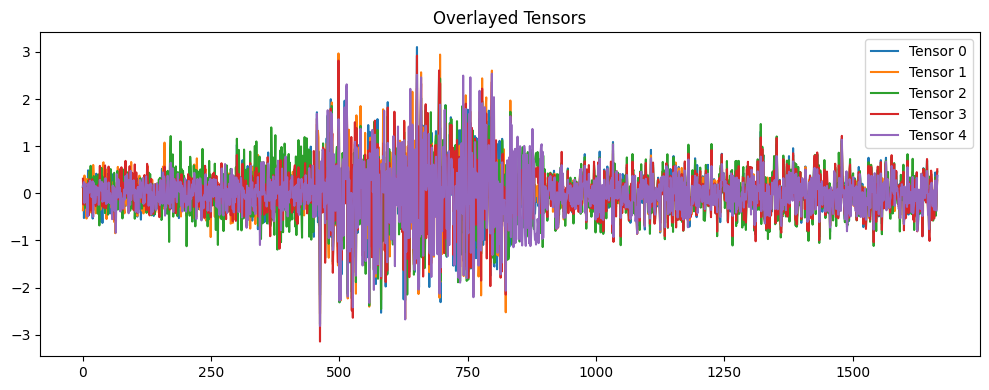

In [ ]:
plot_tensors(_fted[0:5])

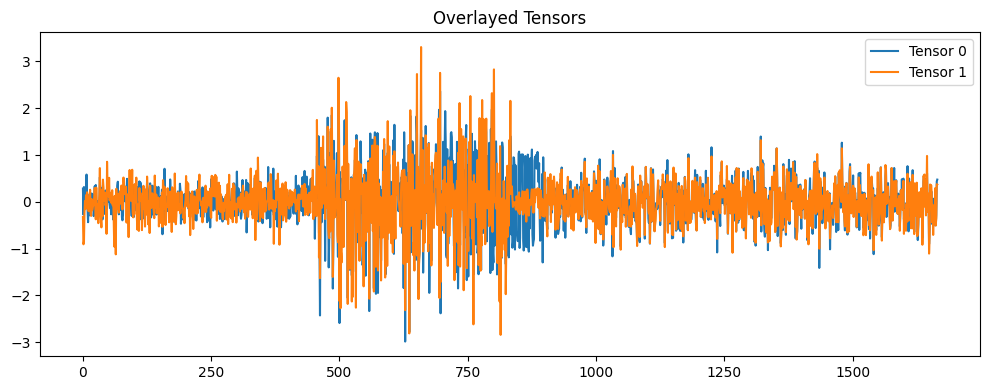

In [ ]:
plot_tensors(_fted[5:7])

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_tensor_chunks(tensor_list, labels=None, title_prefix="Tensor", overlay=True):
  """
  Plot 10 tensors (each length 1666) in 4 fixed index chunks as scatter plots.
  Chunks:
    1. 0-449
    2. 450-833
    3. 834-897
    4. 898-1665
  """
  assert all(t.shape[0] == 1666 for t in tensor_list), "All tensors must be of length 1666"
  if labels is None:
      labels = [f"tensor_{i}" for i in range(len(tensor_list))]

  chunks = [(0, 450), (450, 834), (834, 898), (898, 1666)]
  chunk_titles = ["Chunk 0–449", "Chunk 450–833", "Chunk 834–897", "Chunk 898–1665"]

  for i, (start, end) in enumerate(chunks):
      plt.figure(figsize=(12, 4))
      for j, t in enumerate(tensor_list):
          chunk = t[start:end].detach().cpu().numpy()
          plt.scatter(range(start, end), chunk, s=10, label=labels[j])  # plot as points
      plt.title(f"Tensor Chunk {i+1}: {chunk_titles[i]}")
      plt.xlabel("Index")
      plt.ylabel("Value")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()


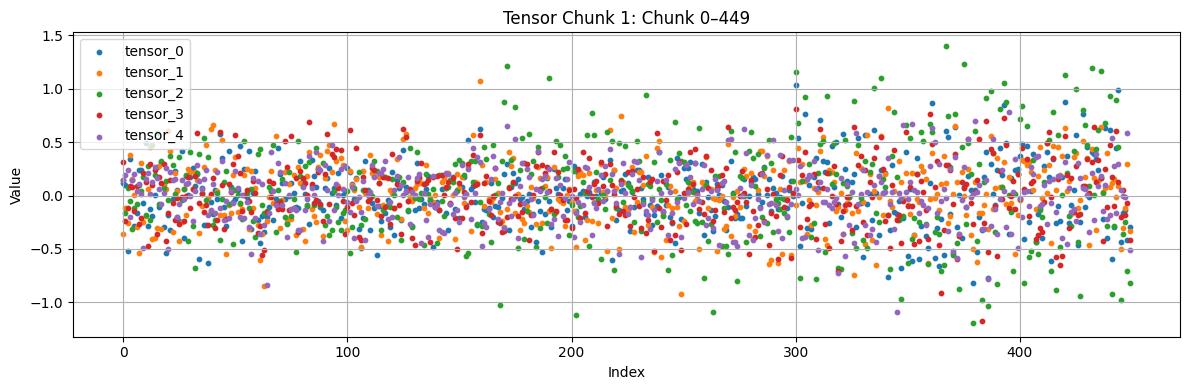

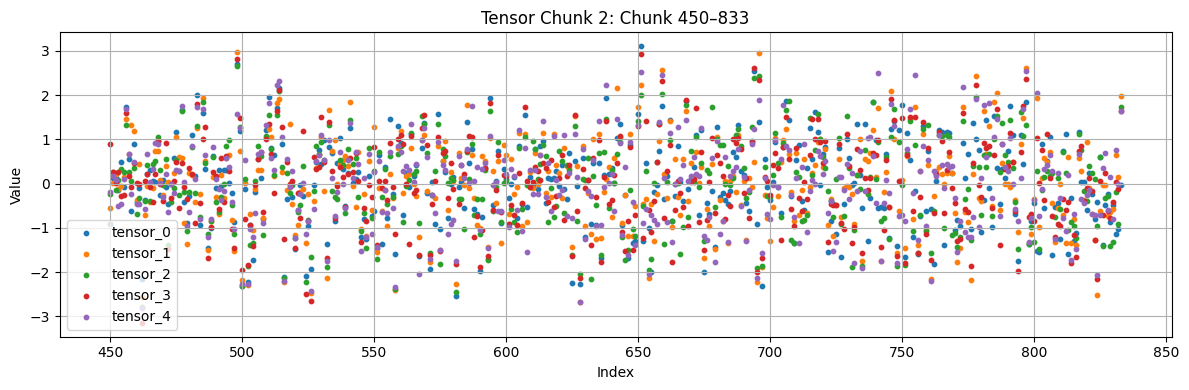

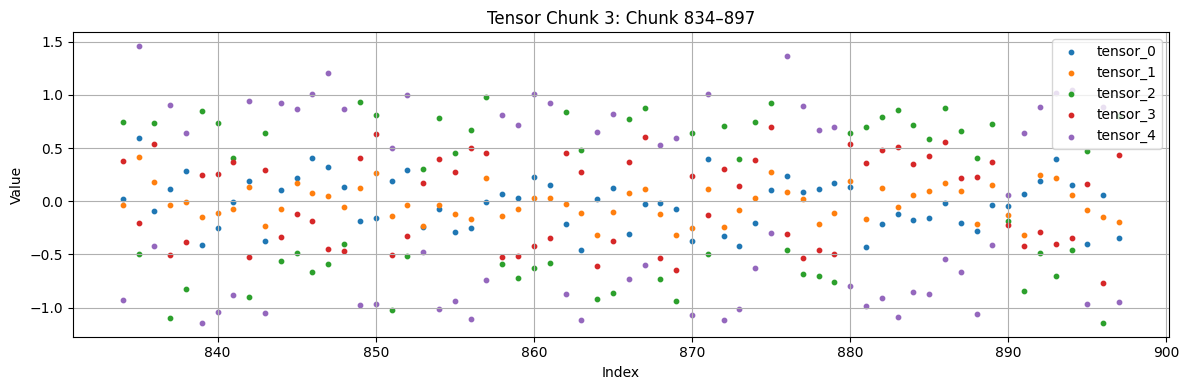

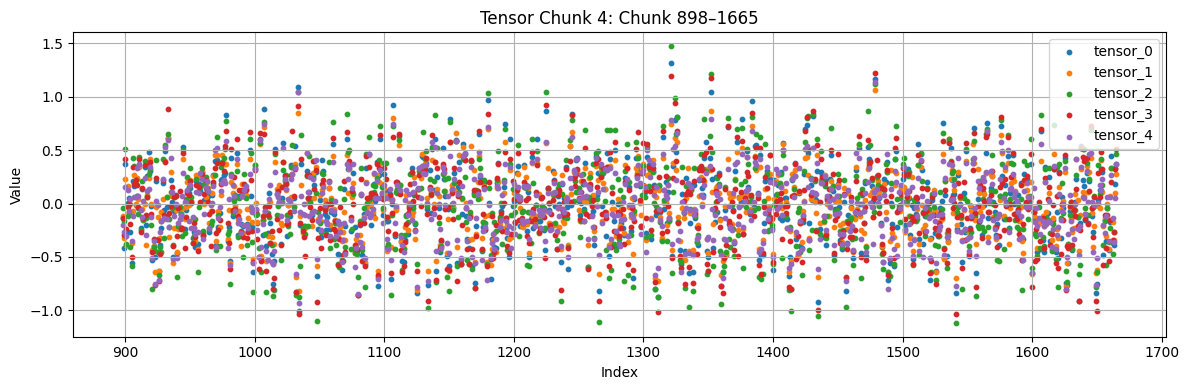

In [ ]:
plot_tensor_chunks(_fted[0:5])

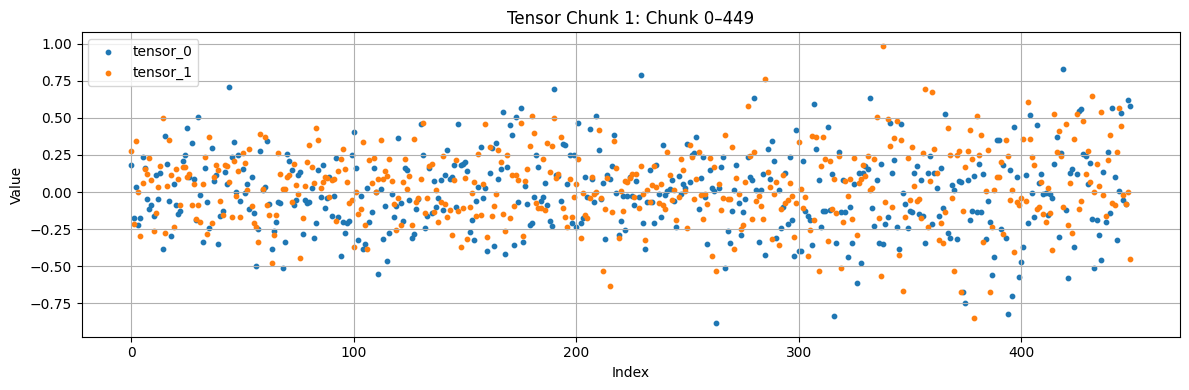

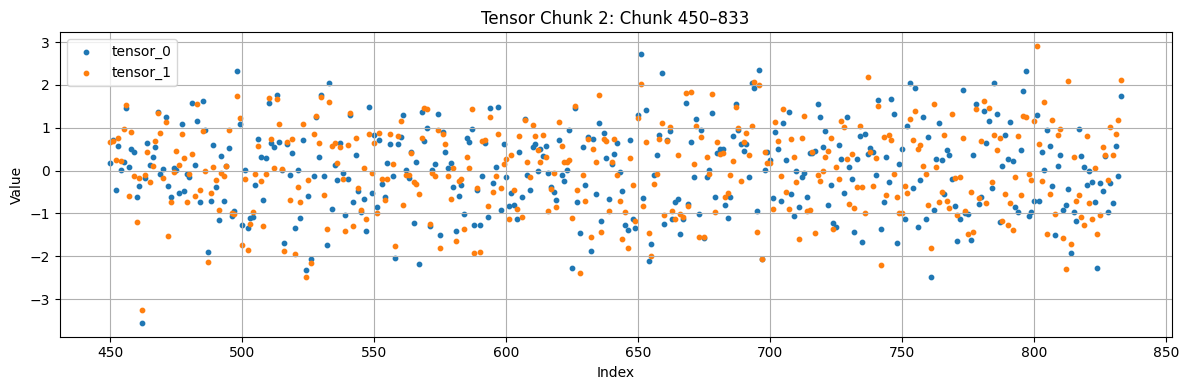

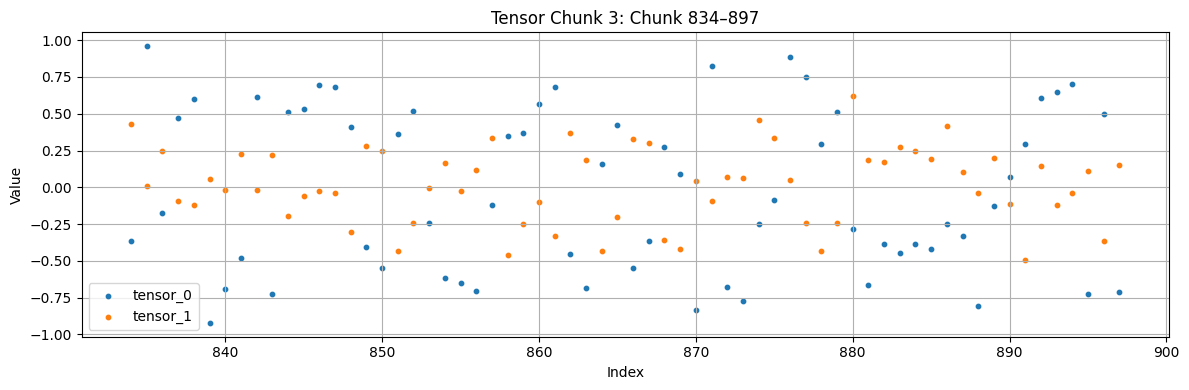

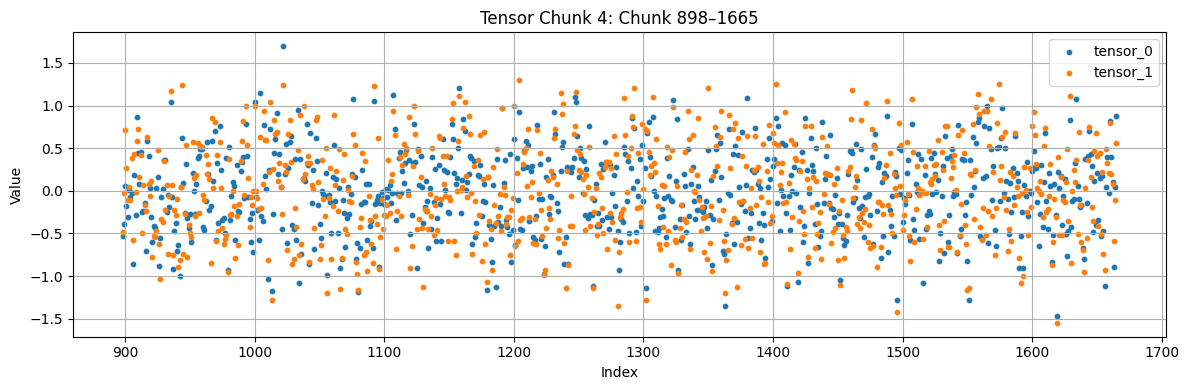

tensor([[1],
        [1]])

In [ ]:
plot_tensor_chunks(_fted[7:9])
_ftedY[7:9]

In [ ]:
import torch

def get_feature_importance(model, input_tensor, target_class=None):
    """
    Returns Grad, Prediction, and L2-normalized input for a single input sample.

    input_tensor: shape [1, 1666]
    Returns:
        - gradient: Tensor of shape [1666]
        - prediction: int (predicted class)
        - normalized_input: Tensor of shape [1666]
    """
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    # Normalize to unit L2 norm
    norm = torch.norm(input_tensor, p=2, dim=1, keepdim=True) + 1e-8
    normalized_input = input_tensor / norm

    # Forward pass
    output = model(normalized_input)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass
    loss = output[0, target_class]
    loss.backward()

    # Gradient w.r.t. normalized input
    gradient = normalized_input.grad[0] if normalized_input.grad is not None else input_tensor.grad[0]

    return gradient.detach(), output.argmax(dim=1).item(), normalized_input.detach()[0]


In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance_with_values_dual_axis(feature_tensor, importance_tensor, top_n=20, note=None):
    """
    Plot top_n features using dual y-axes.
    - Importance on the left y-axis (red dots)
    - Feature values on the right y-axis (blue dots)
    - X-axis is the feature index (ordered)
    """
    # Convert to numpy
    values = feature_tensor.detach().cpu().numpy()
    importances = importance_tensor.detach().cpu().numpy()

    # Get top N indices by absolute importance
    top_indices = (importances).argsort()[-top_n:]
    top_indices_sorted = sorted(top_indices)  # Sort by feature index

    x = top_indices_sorted
    y_imp = importances[top_indices_sorted]
    y_val = values[top_indices_sorted]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # First axis for importance
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Importance', color='red')
    ax1.scatter(x, y_imp, color='red', label='Importance', marker='o')
    ax1.tick_params(axis='y', labelcolor='red')

    # Second axis for feature value
    ax2 = ax1.twinx()
    ax2.set_ylabel('Feature Value', color='blue')
    ax2.scatter(x, y_val, color='blue', label='Feature Value', marker='x')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title(f'Top {top_n} Features: Importance vs Value (Dual Axis, Dots Only)'+f" {note}")
    fig.tight_layout()
    plt.show()


<ipython-input-618-a169470dbdaf>:29: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradient = normalized_input.grad[0] if normalized_input.grad is not None else input_tensor.grad[0]


For item 7 model predicted 0 | real 1


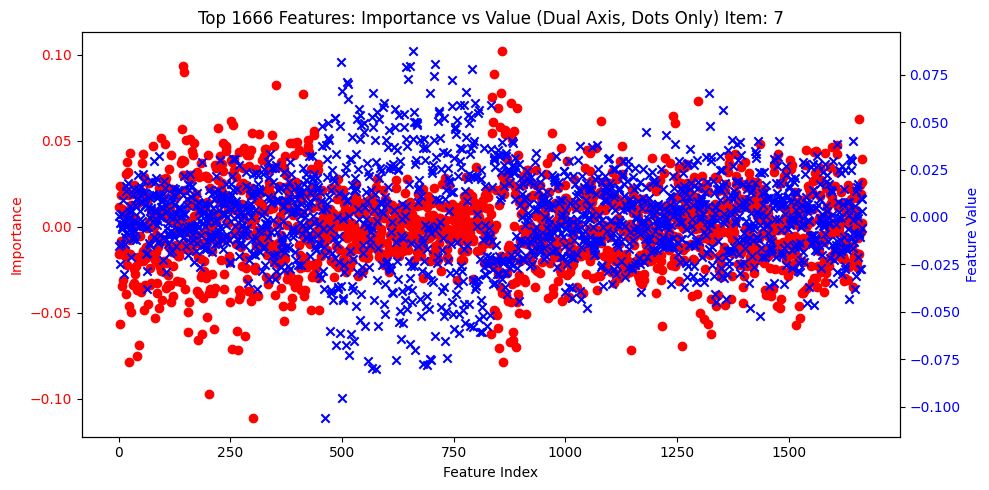

For item 9 model predicted 1 | real 0


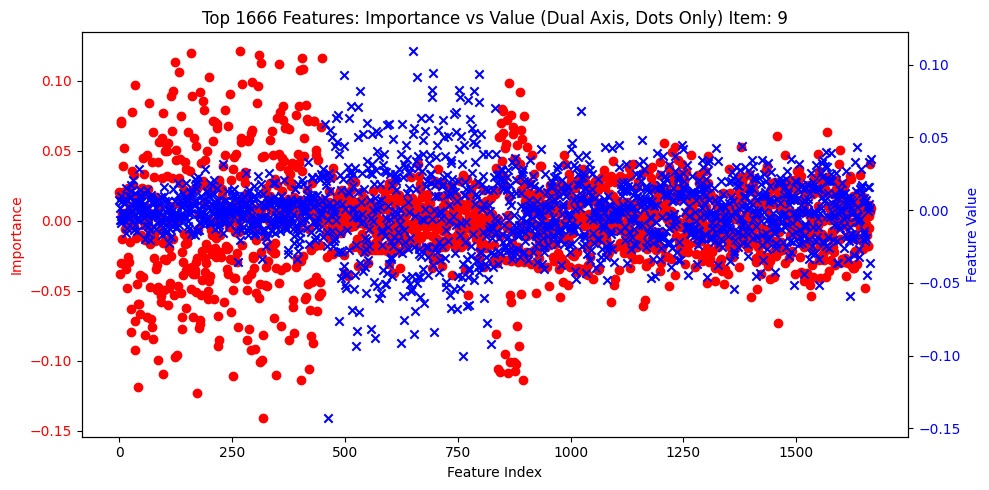

For item 14 model predicted 0 | real 1


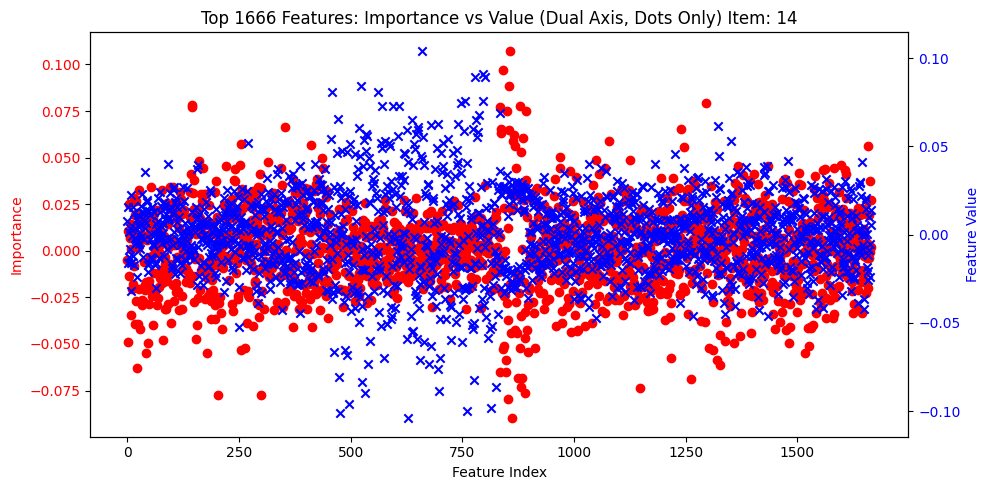

For item 15 model predicted 1 | real 0


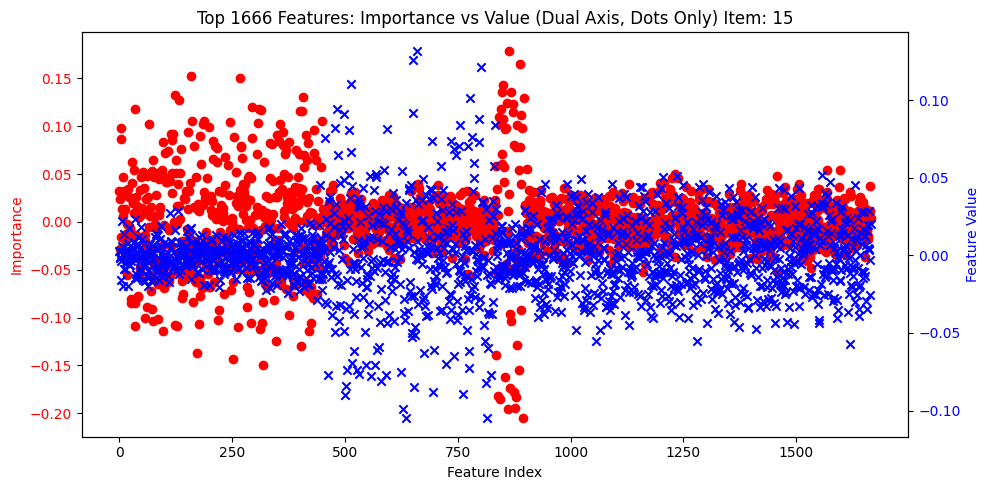

In [ ]:
# One sample
for i in range(0,20):
  importance,pred,norm = get_feature_importance(_model4, sample, target_class=_ftedY[i])
  if(pred!=_ftedY[i]):
    sample = _fted[i].unsqueeze(0)  # shape [1, 1666]
    _model4.eval()
    print(f"For item {i} model predicted {pred} | real {_ftedY[i].item()}")
    plot_feature_importance_with_values_dual_axis(importance_tensor=importance, feature_tensor=norm, top_n=1666, note=f"Item: {i}")

<ipython-input-610-83b9cbd712af>:27: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradient = normalized_input.grad[0] if normalized_input.grad is not None else input_tensor.grad[0]


For item 7 model predicted 1 | real 1


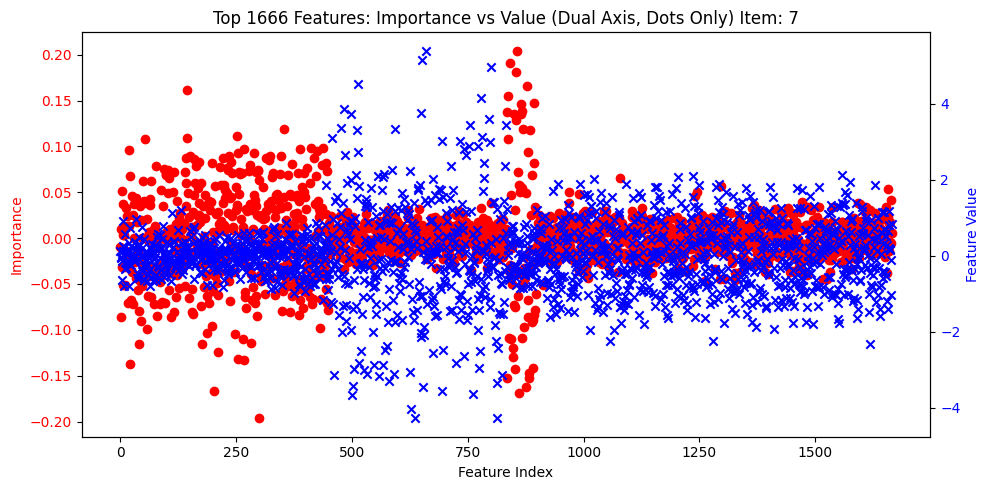

For item 8 model predicted 1 | real 1


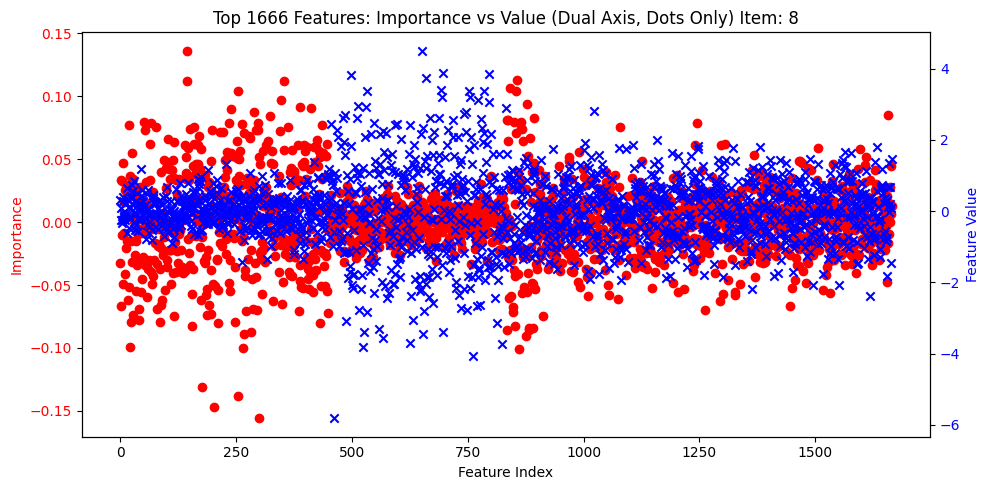

For item 14 model predicted 1 | real 1


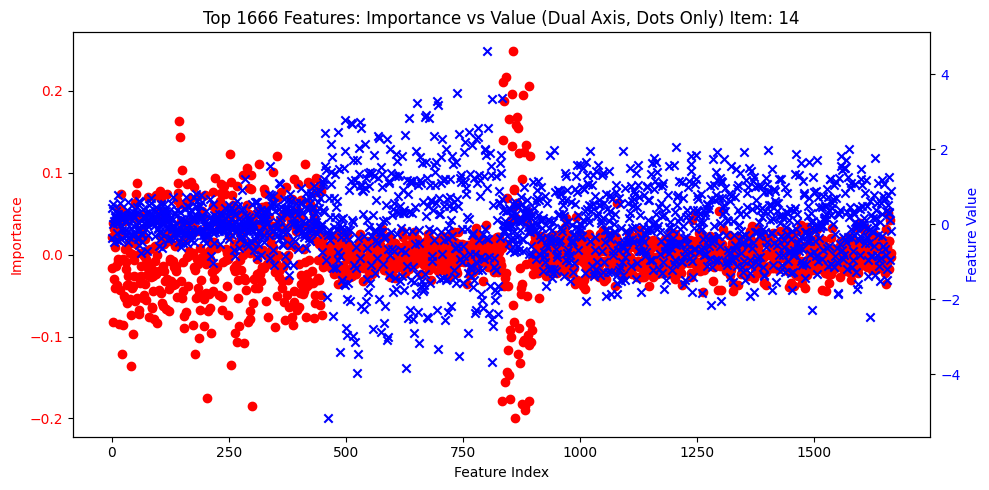

In [ ]:
# One sample
for i in range(0,20):
  importance,pred,norm = get_feature_importance(_model4, sample, target_class=_ftedY[i])
  if(pred==_ftedY[i]):
    sample = _fted[i].unsqueeze(0)  # shape [1, 1666]
    _model4.eval()
    print(f"For item {i} model predicted {pred} | real {_ftedY[i].item()}")
    plot_feature_importance_with_values_dual_axis(importance_tensor=importance, feature_tensor=norm, top_n=1666, note=f"Item: {i}")

In [ ]:
# One sample
for i in range(0,20):
  importance,pred,norm = get_feature_importance_norm(_model4, sample, target_class=_ftedY[i])
  if(pred==_ftedY[i]):
    sample = _fted[i].unsqueeze(0)  # shape [1, 1666]
    _model4.eval()
    print(f"For item {i} model predicted {pred} | real {_ftedY[i].item()}")
    plot_feature_importance_with_values_dual_axis(importance, sample[0], top_n=1666, note=f"Item: {i}")

# End

In [ ]:
data = torch.load("model_TwinTransformer.pth", map_location=torch.device('cpu'))